In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy import interpolate
import h5py
import pickle
import constants as cst

import sys
import os
import subprocess
from copy import copy
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook

import Reading_Scripts as Reading
import kgrid as kgrid
import Photo_Emission as Photo
import Incoherent_Photo_Emission as Incoherent
import Incoherent_Functions as Incoherent_Fitting
import honeycomb as honey
from geometry import LightGeometry
from colormaps import cmap_arpes3,cmap_arpes3_invert


import time

np.set_printoptions(threshold=np.inf)

In [2]:
#tipo_Hamiltoniano = 'blackp'
tipo_Hamiltoniano = 'Hqpgw_new'

ang = 1.0 / 0.5291772
a1 = np.array([3.31067978852923, 0.0, 0.0]) * ang
a2 = np.array([0.0, 4.58545824667620, 0.0]) * ang
a3 = np.array([0.0, 0.0,  10.9888937548268 ]) * ang

b1,b2,b3 = honey.GetRecLatt(a1,a2,a3)

vectores = {
    'a1' : a1,
    'a2' : a2,
    'a3' : a3,
    'b1' : b1,
    'b2' : b2,
    'b3' : b3
    
}

system="BlackP"
out_path = "./../../OUT/"
path = "./../../DATA/data_excitons/"+system+"/"
path_population = "./../../DATA/data_Boltzmann_equation/populations/"
excitons_out = "Excitonic_Wave_Functions_out"

data_path = out_path + excitons_out + '/' + 'out_' + tipo_Hamiltoniano + '_merlin_new_screening'

nkx=72
nky=72
nkz=72
nk =np.array([nkx,nky,nkz])

Q_grid =[0.0278,0.0556]
Q_plots = np.sort(list([0.0])+list(Q_grid)+list(-np.array(Q_grid)))

direccion = 'kx'
Cx,Σx,X0x,Ax,X_max_x,Y_max_x,ϵ_x = Incoherent_Fitting.parameters_numerics(direccion,Q_plots,nk,data_path)
X_max_x = Incoherent_Fitting.inter(Q_plots,X_max_x)
Y_max_x = Incoherent_Fitting.inter(Q_plots,Y_max_x)
X0_x    = Incoherent_Fitting.inter(Q_plots,X0x)
Σ_x     = Incoherent_Fitting.inter(Q_plots,Σx)


direccion = 'ky'
Cy,Σy,X0y,Ay,X_max_y,Y_max_y,ϵ_y = Incoherent_Fitting.parameters_numerics(direccion,Q_plots,nk,data_path)
X_max_y = Incoherent_Fitting.inter(Q_plots,X_max_y)
Y_max_y = Incoherent_Fitting.inter(Q_plots,Y_max_y)
X0_y    = Incoherent_Fitting.inter(Q_plots,X0y)
Σ_y     = Incoherent_Fitting.inter(Q_plots,Σy)


direccion = 'kz'
Cz,Σz,X0z,Az,X_max_z,Y_max_z,ϵ_z = Incoherent_Fitting.parameters_numerics(direccion,Q_plots,nk,data_path)
X_max_z = Incoherent_Fitting.inter(Q_plots,X_max_z)
Y_max_z = Incoherent_Fitting.inter(Q_plots,Y_max_z)
X0_z    = Incoherent_Fitting.inter(Q_plots,X0z)
Σ_z     = Incoherent_Fitting.inter(Q_plots,Σz)

ϵ_parameters = np.array(Incoherent_Fitting.energy_interp(Q_plots,ϵ_x,ϵ_y,ϵ_z))
ϵ_parameters[0]+=-0.007218415494380028 ##binding enery of 0.31 with respect to the 0.506
nk_interp = 150
x1_interp = np.linspace(-0.5,0.5, nk_interp+1)[0:-1]
nq = 21
#print(ϵ_parameters[0]*cst.Ry)

In [3]:
delta=0.1
θ=20

angulo=(θ+90)/180*np.pi
n_kpts =150
#=======================================================================================
if tipo_Hamiltoniano == 'Hqpgw_new':
    scissor_index = 20
    scissor_energy = -0.007218415494380028
    Eshift = 0.4775761822256256# / cst.Ry
#=======================================================================================

#=======================================================================================
if tipo_Hamiltoniano == 'blackp':
    scissor_index = 20
    #scissor_energy = 0.36117191605020593 / cst.Ry
    scissor_energy = 0.009545841834455716#0.45575558560067403 / cst.Ry
    #scissor_energy = 0.45575558560067403 / cst.Ry
    Eshift = -6.5933131643874745#/ cst.Ry
#=======================================================================================

bandas_info = {
    'scissor_index': scissor_index,
    'scissor_energy':scissor_energy
}
ibnd_min = 19
ibnd_max = 20
bands = np.arange(ibnd_min, ibnd_max+1, step=1)

kpath = {
    'nk': n_kpts,
    'kmin' :  -delta,
    'kmax' :   delta,
    'angulo': angulo
}

fname = path + "BlackP_grid_nk"+str(nkx)+"x"+str(nky)+"x"+str(nkz)+"_"+tipo_Hamiltoniano+"_wann_calc.h5"
Energies = Reading.ReadBands(fname) + Eshift/cst.Ry
Energie_no_Valence  = Energies[:,ibnd_min -1] 
Energie_Valence     = Energies[:,ibnd_min] 
Energie_Conduction  = Energies[:,ibnd_max]  + scissor_energy

μ_chem = (0.50559/2.)/cst.Ry
β = 1.0#0.1/μ_chem
wmin, wmax = -.4 / cst.Ry, .7 / cst.Ry
#wmin, wmax = -1.4 / cst.Ry, 1.0 / cst.Ry
N_Ep = 300
EnergySpectrum = np.linspace(wmin, wmax, N_Ep)
tolerancia = 0.0004

In [4]:
Q_grid=np.linspace(-0.035,0.035,nq)

Ec_k_0  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Conduction,[0.0,0.0,0.0])
Ev_k_0  = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Valence,[0.0,0.0,0.0])
Env_k_0 = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_no_Valence,[0.0,0.0,0.0])  
ρ_total_0,ϵ_total_0 = Incoherent_Fitting.parameters(x1_interp,[0.0,0.0,0.0],Q_plots,X_max_x,Y_max_x,X0_x,Σ_x,X_max_y,Y_max_y,X0_y,Σ_y,X_max_z,Y_max_z,X0_z,Σ_z,ϵ_parameters)


x_kpts = np.linspace(0-delta,0+delta,n_kpts)

#x_kpts_cart

k_points_path_k = np.array([[0.0,-delta*np.sin(angulo),-delta*np.cos(angulo)],\
                            [0.0, delta*np.sin(angulo), delta*np.cos(angulo)]])

new_path_k = kgrid.K_PATH(k_points_path_k,n_kpts)

Ec_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ec_k_0,new_path_k)
Ev_kpts  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_0,new_path_k)
Env_kpts = Photo.FourierInterpolate(nkx,nky,nkz,Env_k_0,new_path_k)


###---------------------------------k_z smearing----------------------------------
delta_z  =  0.08
kz_smearing = np.arange(-2*delta_z,2*delta_z + 0.01,0.01)

Ev_z_kpts = np.zeros((np.shape(kz_smearing)[0],n_kpts))


for i,z_repetitions in enumerate(kz_smearing):

    k_points_path_k = np.array([[z_repetitions,-delta*np.sin(angulo),-delta*np.cos(angulo)],\
                                [z_repetitions, delta*np.sin(angulo), delta*np.cos(angulo)]])
    
    new_path_k = kgrid.K_PATH(k_points_path_k,n_kpts)
    Ev_z_kpts[i] = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_0,new_path_k)

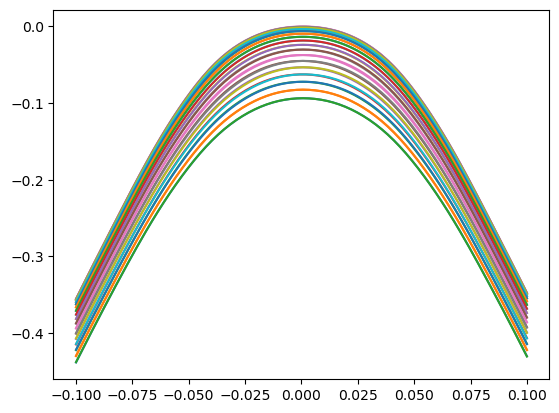

In [5]:
for i,z_repetitions in enumerate(kz_smearing):

    plt.plot(x_kpts,Ev_z_kpts[i]*cst.Ry)

0.8439500138365241


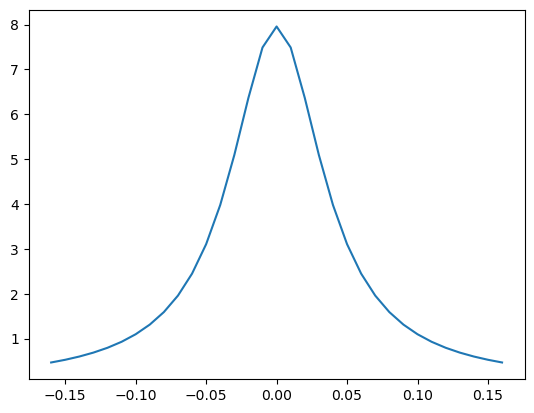

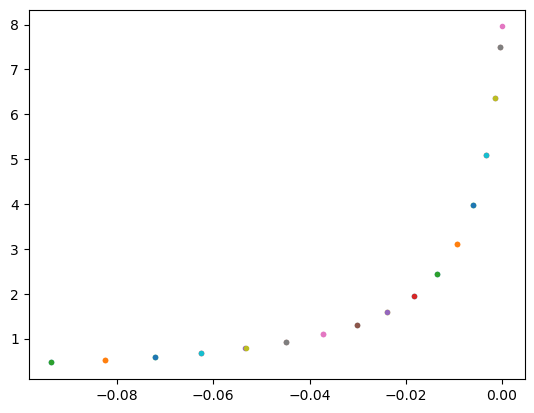

In [6]:
def Lorentz_smearing(k,Γ):
    return 1.0/np.pi*(0.5*Γ)/(k**2 + (0.5*Γ)**2 )

plt.figure()
plt.plot(kz_smearing,Lorentz_smearing(kz_smearing,0.08))

plt.figure()
for i,z_repetitions in enumerate(kz_smearing):

    plt.plot(np.max(Ev_z_kpts[i]*cst.Ry),Lorentz_smearing(z_repetitions,0.08),'.')
print(np.trapz(Lorentz_smearing(kz_smearing,0.08),kz_smearing))

In [5]:
Q_points = np.zeros((nq**3,3))

contador=0
for qq_ii in range(len(Q_grid)):
    for qq_jj in range(len(Q_grid)):
        for qq_kk in range(len(Q_grid)):
            Q_points[contador,:] = np.array([ Q_grid[qq_ii],Q_grid[qq_jj],Q_grid[qq_kk]  ])
            contador+=1

In [ ]:
from joblib import Parallel, delayed

def compute_slice(qq_ii):

    ϵ_total_slice = np.zeros((len(Q_grid), len(Q_grid)))
    Ψ_kpts_slice  = np.zeros((len(Q_grid), len(Q_grid), nk_interp))
    Ev_Qpts_slice = np.zeros((len(Q_grid), len(Q_grid), nk_interp))
    
    
    for qq_jj in range(len(Q_grid)):
        for qq_kk in range(len(Q_grid)):

            Q_interp_x = Q_grid[qq_ii]
            Q_interp_y = Q_grid[qq_jj]
            Q_interp_z = Q_grid[qq_kk]
            QQ = np.array([Q_interp_x,Q_interp_y,Q_interp_z])
            
            ρ_total, ϵ_total_slice[qq_jj, qq_kk] = Incoherent_Fitting.parameters(
                x1_interp, QQ, Q_plots, X_max_x, Y_max_x, X0_x, Σ_x,
                X_max_y, Y_max_y, X0_y, Σ_y, X_max_z, Y_max_z, X0_z, Σ_z, ϵ_parameters
                                                    )
            
            Ev_k_p = Photo.SHIFTING_KplusP(nkx,nky,nkz,Energie_Valence,QQ)
            
            
            k_points_path_Q = np.array([[-Q_interp_x,-delta,-Q_interp_z],[-Q_interp_x,delta,-Q_interp_z]])
            
            new_path_Q = kgrid.K_PATH(k_points_path_Q,n_kpts)

            #Ψ_kpts[qq_ii,qq_jj,qq_kk,:]   = Photo.FourierInterpolate(nk_interp,nk_interp,nk_interp,ρ_total,new_path_Q)
            #Ev_Qpts[qq_ii,qq_jj,qq_kk,:]  = Photo.FourierInterpolate(nkx,nky,nkz,Ev_k_p,new_path_Q)


            Ψ_kpts_slice[qq_jj, qq_kk, :]  = Photo.FourierInterpolate(nk_interp,nk_interp, nk_interp, ρ_total, new_path_Q)
            Ev_Qpts_slice[qq_jj, qq_kk, :] = Photo.FourierInterpolate(nkx, nky, nkz, Ev_k_p, new_path_Q)

    return ϵ_total_slice, Ψ_kpts_slice, Ev_Qpts_slice
            

def parallel_nested_loop():

    results = Parallel(n_jobs=4)(
        delayed(compute_slice)(qq_ii) for qq_ii in range(len(Q_grid)) )
    
    ϵ_total = np.zeros((len(Q_grid), len(Q_grid), len(Q_grid)))
    Ψ_kpts  = np.zeros((len(Q_grid), len(Q_grid), len(Q_grid), nk_interp))
    Ev_Qpts = np.zeros((len(Q_grid), len(Q_grid), len(Q_grid), nk_interp))

    for qq_ii, (ϵ_slice, Ψ_k_slice, Ev_Q_slice) in enumerate(results):
        ϵ_total[qq_ii, :, :]    = ϵ_slice
        Ψ_kpts[qq_ii, :, :, :]  = Ψ_k_slice
        Ev_Qpts[qq_ii, :, :, :] = Ev_Q_slice
        
    return ϵ_total, Ψ_kpts, Ev_Qpts

start_time = time.time()
ϵ_total, Ψ_kpts, Ev_Qpts = parallel_nested_loop() 
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

1.9198621771937625 110.0
1.9198621771937625 110.0


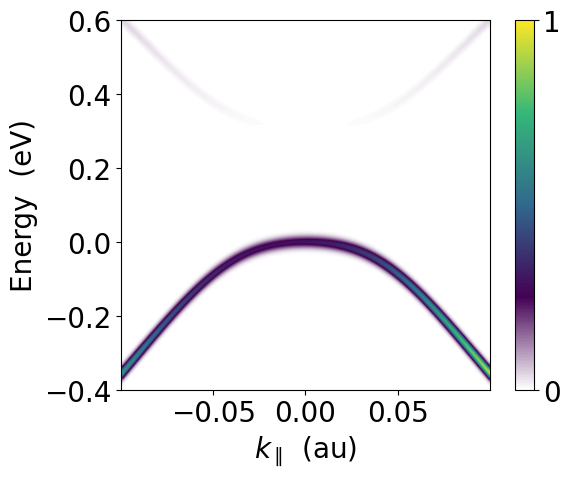

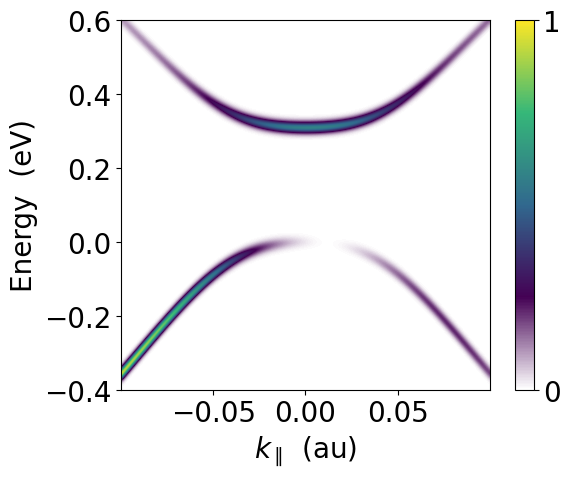

In [7]:
alpha = 55

photon = {
    'wphot': 6.2,
    'alpha': alpha,
    'Vin': 0.0,
    'Phiw': 4.95409,
    'Eshift': Eshift,
    #'rint': [0.2, 1.0, 2.0],
    'rint': [4.2, 3.8, 2.0],
    #'eta': 0.002
    'eta': tolerancia
}
    
geo = LightGeometry(alpha/180. * np.pi, θ/180. * np.pi, 1.0)
pol_p = geo.GetPol_p_i()
pol_s = geo.GetPol_s_i()


kpath['dir'] = 'dif'
polarization = {'tag': 's', 'vector': pol_s}
mel_pol_s = Incoherent_Fitting.GenMatrixElements(tipo_Hamiltoniano,vectores,EnergySpectrum,kpath,polarization,bands,bandas_info,photon,fout='Matrix_Elements_Pol_s')

polarization = {'tag': 'p', 'vector': pol_p}
mel_pol_p = Incoherent_Fitting.GenMatrixElements(tipo_Hamiltoniano,vectores,EnergySpectrum,kpath,polarization,bands,bandas_info,photon,fout='Matrix_Elements_Pol_p')


In [8]:
hf = h5py.File(path + 'IncoherentesQ'+tipo_Hamiltoniano+'_nq='+str(nq)+'.h5', 'w')

hf.create_dataset('Q_grid'  , data = Q_points  )
hf.create_dataset('Ψ_kpts'  , data = Ψ_kpts  )
hf.create_dataset('Ev_Qpts' , data = Ev_Qpts )
hf.create_dataset('ϵ_total' , data = ϵ_total )

hf.close()





In [8]:
fname = path + 'IncoherentesQ'+tipo_Hamiltoniano+'_nq='+str(nq)+'.h5'
print(fname)
f = h5py.File(fname, "r")
Q_points  = np.array(f['Q_grid'])
Ψ_kpts  = np.array(f['Ψ_kpts'])
Ev_Qpts = np.array(f['Ev_Qpts'])
ϵ_total = np.array(f['ϵ_total'])

f.close()

γ = 0.00000001
γ_i = γ
switch='on'
FWHM = f"{300:.2f}"
α = f"{0.03:.3f}"

if switch=='on':
    fname = path_population  + 'Boltzmann_Evolution_nq='+ str(nq)+ "_γ=" +str(γ)+"_laser="+str(switch)+"_FWHM="+str(FWHM)+"_α="+str(α)+ '.h5'
else:
    fname = path_population  + 'Boltzmann_Evolution_nq='+ str(nq)+ "_γ=" +str(γ)+"_laser="+str(switch) + '.h5'

f = h5py.File(fname, "r")
E_t       = np.array(f['E(t)'])
Q_red     = np.array(f['Q_grid'])
Boltzmann = np.array(f['P_q(t)'])
time_evol = np.array(f['time'])

f.close()

Ψ_kpts_n  = np.zeros((nq**3,nk_interp))
Ev_Qpts_n = np.zeros((nq**3,nk_interp))
ϵ_total_n = np.zeros((nq**3))
contador=0
for qq_ii in range(len(Q_grid)):
    for qq_jj in range(len(Q_grid)):
        for qq_kk in range(len(Q_grid)):
            Ψ_kpts_n[contador,:]  = Ψ_kpts[qq_ii,qq_jj,qq_kk,:]
            Ev_Qpts_n[contador,:] = Ev_Qpts[qq_ii,qq_jj,qq_kk,:]
            ϵ_total_n[contador]   = ϵ_total[qq_ii,qq_jj,qq_kk]
            contador+=1

del Ψ_kpts; del Ev_Qpts; del ϵ_total

./../../DATA/data_excitons/BlackP/IncoherentesQHqpgw_new_nq=21.h5


In [9]:
#maximos = {}
#for jq,q_red in enumerate(Q_red):

#    array =[]
#    for iq, qq in enumerate(Q_points[:]):
#        if np.all( np.abs(np.round(qq,5))== np.abs(np.round(q_red,5)) ):

#            array.append(iq)
#    maximos[jq] = array


maximos=np.zeros((nq**3),dtype=np.int64)
for iq, qq in enumerate(Q_points[:]):
    for jq,q_red in enumerate(Q_red):
        if np.all( np.abs(np.round(qq,5))== np.abs(np.round(q_red,5)) ):
            
            maximos[iq] = jq
            break
            
#maximos

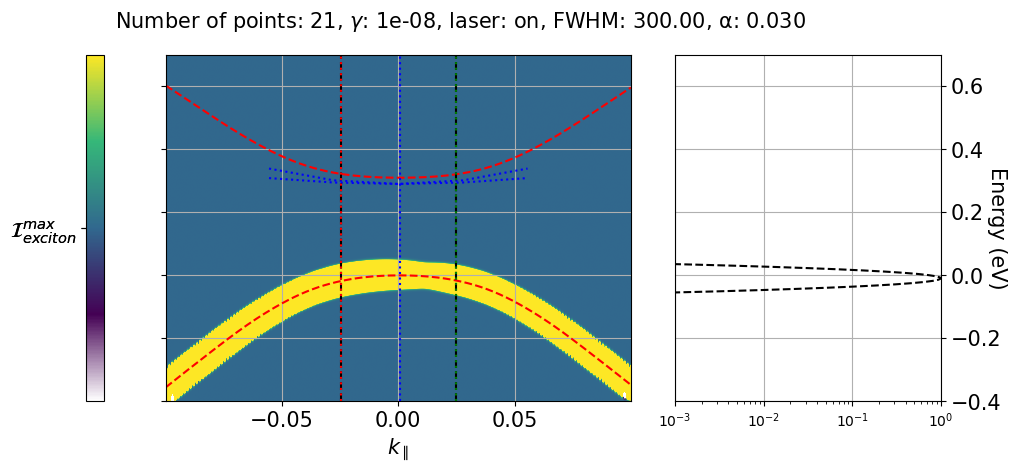

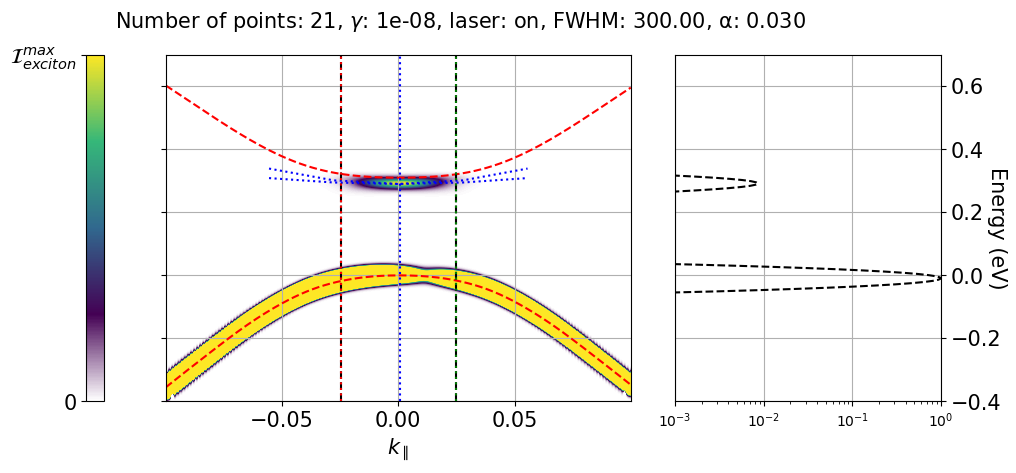

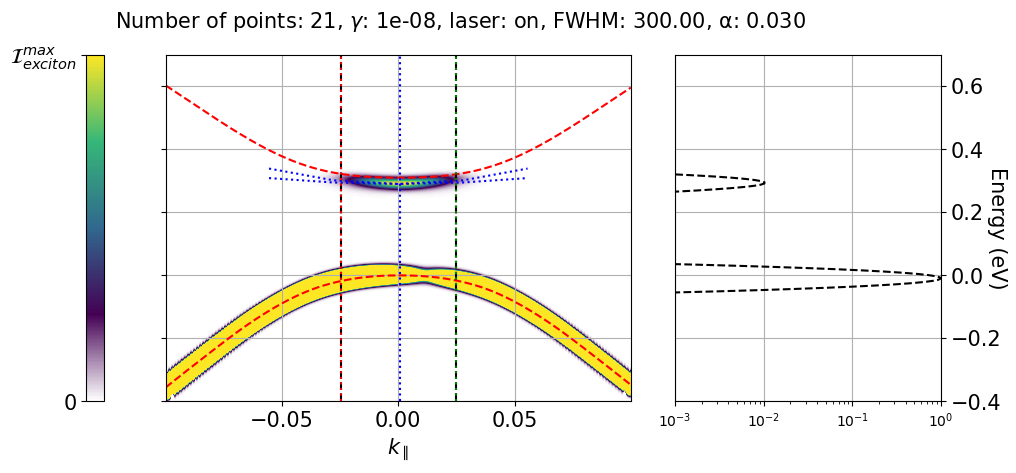

In [ ]:
nsnap = 4
step = len(time_evol) // nsnap
dist = Boltzmann[:,::step]

Intensity_V  = np.zeros((len(EnergySpectrum),n_kpts))
for ω_ii in range(len(EnergySpectrum)):
    for kk in range(np.shape(Ev_kpts)[-1]):#*abs(mel_pol_p[1,kk,ω_ii])**2
        Intensity_V[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia)\
            *abs(mel_pol_p[0,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])
        
IntensityV_plot  = Intensity_V[:,:].reshape(len(EnergySpectrum),n_kpts)[:,:]

for tsnap in range(nsnap):
    Intensity_E  = np.zeros((nq**3,len(EnergySpectrum),n_kpts))

    for ω_ii in range(len(EnergySpectrum)):
        for kk in range(np.shape(Ev_kpts)[-1]):#*abs(mel_pol_p[1,kk,ω_ii])**2
            Intensity_E[:,ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_Qpts_n[:,kk]- ϵ_total_n[:], tolerancia)\
                *abs(Ψ_kpts_n[:,kk])            *dist[maximos[:],tsnap] *abs(mel_pol_p[1,kk,ω_ii])**2

    IntensityE_plot =np.zeros((len(EnergySpectrum),n_kpts))
    for qq_ii in range(nq**3):
    #    Funcion_Particion += Incoherent.partition_weight(ϵ_total_n[qq_ii],β)/Incoherent.partition_weight(ϵ_total_0,β)
        IntensityE_plot += Intensity_E[qq_ii,:,:].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]

    
    #IntensityE_plot*=1/Funcion_Particion
    #factor=np.max(IntensityV_plot)/np.max(IntensityE_plot) 
    
    Intensity = IntensityE_plot + IntensityV_plot

    
    k_start = -0.025  # Start of the range
    k_end = 0.025    # End of the range


    mask = (x_kpts >= k_start) & (x_kpts <= k_end)
    

    #integral = np.trapz(Intensity[:,mask], x_kpts[mask])
    
    integral  = np.sum(Intensity[:,mask], axis=1)
    integral *= 1/(np.sum(mask))
    
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), gridspec_kw={'width_ratios': [3.5, 1.5]})
    
    if switch == 'on':
        plt.suptitle(f'Number of points: {nq}, $\\gamma$: {γ}, laser: {switch}, FWHM: {FWHM}, α: {α}', fontsize=15)
    else:
        plt.suptitle(f'Number of points: {nq}, $\\gamma$: {γ}, laser: {switch}', fontsize=15)

    cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

    a = axes[0].imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
               extent=[x_kpts.min(),x_kpts.max(),\
                       cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
                origin='lower',aspect='auto',interpolation ='spline36',cmap = cmap_arpes3())
                #origin='lower',aspect='auto',interpolation ='spline36',cmap = 'afmhot_r')

    cbar = fig.colorbar(a, ax=axes[0],ticks=[0, np.max(np.abs(IntensityE_plot)) ], location='left')
    cbar.ax.set_yticklabels([0, r'$\mathcal{I}_{exciton}^{max}$'],fontsize=15)



    axes[0].plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_x-0.007218415494380028),':',color='blue' )
    axes[0].plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_y-0.007218415494380028),':',color='blue' )
    #ax1.plot(x_kpts, cst.Ry *(Ev_Qpts + ϵ_total),':',color='blue')
    #ax1.plot(x_kpts, cst.Ry *Ev_Qpts,':',color='blue')
    axes[0].plot(x_kpts, cst.Ry *Ev_kpts,'--',color='red')
    axes[0].plot(x_kpts, cst.Ry *(Ec_kpts),'--',color='red')
    axes[0].set_ylim(wmin * cst.Ry,wmax * cst.Ry)
    axes[0].set_xlim(-.1,0.1)
    axes[0].set_xlabel(r"$k_{\parallel}$",fontsize=15)
    
    axes[0].set_xticks([-0.05,0.0,0.05])
    
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].axvline(x=x_kpts[mask][0],linestyle='--',color='black')
    axes[0].axvline(x=x_kpts[75],linestyle=':',color='blue')
    axes[0].axvline(x=x_kpts[mask][-1],linestyle='--',color='black')
    axes[0].axvline(x=x_kpts[mask][0],linestyle=':',color='red')
    axes[0].axvline(x=x_kpts[mask][-1],linestyle=':',color='green')
    axes[0].grid()
    
    
    #axes[1].plot(np.abs(np.mean(Intensity[:, 55:95], axis=1)),EnergySpectrum*cst.Ry,color='black' )
    #axes[1].plot(np.abs(Intensity[:,55]),EnergySpectrum*cst.Ry,':',color='blue')
    #axes[1].plot(np.abs(Intensity[:,75]),EnergySpectrum*cst.Ry,'--',color='red')
    
    
    
    #axes[1].plot(np.abs(Intensity[:,mask][:,0]),EnergySpectrum*cst.Ry,'--',color='red')    
    #axes[1].plot(np.abs(Intensity[:,75]),EnergySpectrum*cst.Ry,':',color='blue')
    axes[1].plot(integral/np.max(integral),EnergySpectrum*cst.Ry,'--',color='black')
    
    axes[1].set_xscale('log')
    axes[1].set_ylabel(r"Energy (eV)", rotation=-90,fontsize=15)
    axes[1].yaxis.set_label_position("right")
    axes[1].tick_params(axis='y', labelsize=15)
    axes[1].yaxis.tick_right()
    axes[1].set_xlim(0.001, 1)
    
    axes[0].set_yticklabels([])
    #axes[1].plot(EnergySpectrum*cst.Ry,np.abs(Intensity[:,95]),':')
    axes[1].set_ylim(wmin * cst.Ry,wmax * cst.Ry)
    axes[1].grid()
    
    plt.subplots_adjust(wspace=0.1)
    
    
    #plt.savefig("Plots_Using_Boltzmann_Distribution/"+"Spectrum_nq="+str(nq)+"_tsnap="+str(tsnap)+"_γ="+str(γ)+"_laser="+switch+"_integral.png",bbox_inches='tight', transparent=False)
    plt.show()

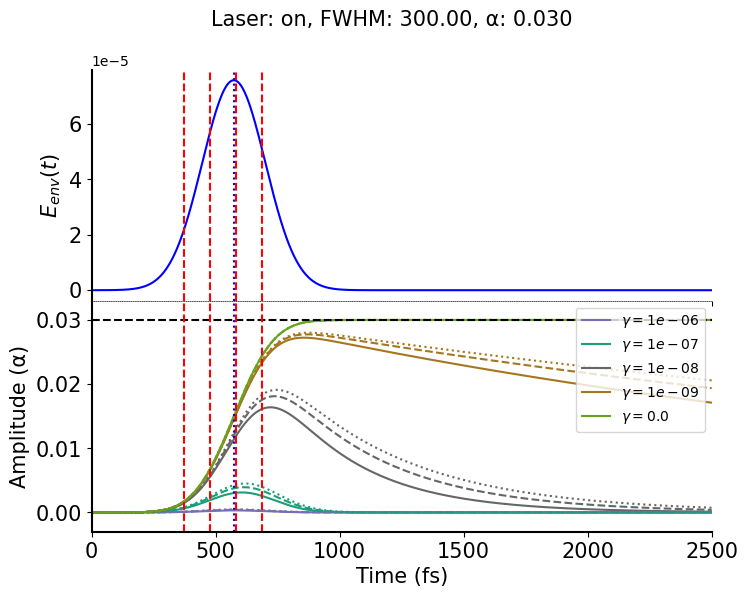

In [14]:
import matplotlib.cm as cm
colors = cm.Dark2(np.linspace(0, 1, 5))
####I have deleted the data nq=31 (it takes a lot of mememory, it can be easily generated running boltzmann)
nq = 31
ancho = 300
#amplitud = 0.001
amplitud = 0.03
τ_0 = 4.5*ancho/(2.0*np.sqrt(2*np.log(2)))


γ = np.array([0.000001,0.0000001,0.00000001,0.000000001,0.00])
#γ = np.array([0.000001])
switch='on'
FWHM = f"{ancho:.2f}"
α = f"{amplitud:.3f}"

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'hspace': 0})

if switch == 'on':
    plt.suptitle(f'Laser: {switch}, FWHM: {FWHM}, α: {α}', fontsize=15)
else:
    plt.suptitle(f'Laser: {switch}', fontsize=15)


if switch=='on':
    fname = path_population + 'Boltzmann_Evolution_nq='+ str(nq)+ "_γ=" +str(γ[0])+"_laser="+str(switch)+"_FWHM="+str(FWHM)+"_α="+str(α)+ '.h5'


f = h5py.File(fname, "r")
E_t       = np.array(f['E(t)'])
Q_red     = np.array(f['Q_grid'])
Boltzmann = np.array(f['P_q(t)'])
time_evol = np.array(f['time'])

f.close()

mask =  (time_evol>= τ_0-200) & (time_evol<= τ_0+200)
filtered_positions = np.where(mask)[0] 
selected_indices = filtered_positions[::300]

ax1.plot(time_evol, E_t, color='blue',linestyle='-')

ax1.set_xlim(0,2500)

for i,γ_i in enumerate(γ):

    if switch=='on':
        fname = path_population + 'Boltzmann_Evolution_nq='+ str(nq)+ "_γ=" +str(γ_i)+"_laser="+str(switch)+"_FWHM="+str(FWHM)+"_α="+str(α)+ '.h5'
    
    
    f = h5py.File(fname, "r")
    Q_red     = np.array(f['Q_grid'])
    Boltzmann = np.array(f['P_q(t)'])
    time_evol = np.array(f['time'])

    f.close()
    
    ax2.plot(time_evol,Boltzmann[0,:],label=f"${{\\gamma}}={γ_i}$",linestyle='-', color=colors[-i+1])
    
    ax2.legend(loc='upper right')
    
    
nq = 21 
for i,γ_i in enumerate(γ):

    if switch=='on':
        fname = path_population + 'Boltzmann_Evolution_nq='+ str(nq)+ "_γ=" +str(γ_i)+"_laser="+str(switch)+"_FWHM="+str(FWHM)+"_α="+str(α)+ '.h5'
    
    
    f = h5py.File(fname, "r")
    Q_red     = np.array(f['Q_grid'])
    Boltzmann = np.array(f['P_q(t)'])
    time_evol = np.array(f['time'])

    f.close()
    
    ax2.plot(time_evol,Boltzmann[0,:],label=f"${{\\gamma}}={γ_i}$",linestyle='--', color=colors[-i+1])
    
nq = 15

for i,γ_i in enumerate(γ):

    if switch=='on':
            fname = path_population + 'Boltzmann_Evolution_nq='+ str(nq)+ "_γ=" +str(γ_i)+"_laser="+str(switch)+"_FWHM="+str(FWHM)+"_α="+str(α)+ '.h5'


    f = h5py.File(fname, "r")
    Q_red     = np.array(f['Q_grid'])
    Boltzmann = np.array(f['P_q(t)'])
    time_evol = np.array(f['time'])

    f.close()

    ax2.plot(time_evol,Boltzmann[0,:],linestyle=':', color=colors[-i+1])


ax1.axvline(x = τ_0,color='blue',linestyle=':')
ax2.axvline(x = τ_0,color='blue',linestyle=':')
ax2.set_ylim(-amplitud*0.10,amplitud+amplitud*0.10)
ax2.axhline(y=amplitud,color='black',linestyle='--')
ax2.set_xlabel("Time (fs)",fontsize=15)
ax2.set_ylabel("Amplitude (α)",fontsize=15)
ax2.tick_params(axis="x", labelsize=15)
ax2.tick_params(axis="y", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
ax1.set_ylabel("$E_{env} (t)$",fontsize=15)

for i in range(len(selected_indices)):
    ax1.axvline(x = time_evol[selected_indices[i]],color='red',linestyle='--')
    ax2.axvline(x = time_evol[selected_indices[i]],color='red',linestyle='--')

    
ax2.spines['left'].set_visible(True)    # Show the left spine
ax2.spines['bottom'].set_visible(True)  # Show the bottom spine
ax2.spines['right'].set_visible(False)  # Hide the right spine
ax2.spines['top'].set_visible(True)  # Hide the right spine

ax1.spines['left'].set_visible(True)    # Show the left spine
ax1.spines['bottom'].set_visible(False)  # Show the bottom spine
ax1.spines['right'].set_visible(False)  # Hide the right spine
ax1.spines['top'].set_visible(False)  # Hide the right spine

ax2.spines['left'].set_linewidth(1.5)
ax2.spines['top'].set_linewidth(0.5)
ax2.spines['bottom'].set_linewidth(1.5)
ax1.spines['left'].set_linewidth(1.5)
ax2.spines['top'].set_linestyle(':') 

if switch == 'on':
    plt.savefig("Plots_Populations/"+"Populations_laser="+switch+"_FWHM="+str(FWHM)+"_α="+str(α)+".png",bbox_inches='tight', transparent=False)
else:
    plt.savefig("Plots_Populations/"+"Populations_laser="+switch+".png",bbox_inches='tight', transparent=False)

In [50]:
amplitud = 0.016
α = f"{amplitud:.3f}"
ancho = 300
τ_0 = 4.5*ancho/(2.0*np.sqrt(2*np.log(2)))
#γ = np.array([0.000001,0.0000001,0.00000001,0.000000001,0.00])
γ_i = 0.0000001
nq = 21
switch='on'
if switch=='on':
    fname = path_population + 'Boltzmann_Evolution_nq='+ str(nq)+ "_γ=" +str(γ_i)+"_laser="+str(switch)+"_FWHM="+str(FWHM)+"_α="+str(α)+ '.h5'


f = h5py.File(fname, "r")
E_t       = np.array(f['E(t)'])
Q_red     = np.array(f['Q_grid'])
Boltzmann = np.array(f['P_q(t)'])
time_evol = np.array(f['time'])

f.close()


mask =  (time_evol>= τ_0-200) & (time_evol<= τ_0+200)
filtered_positions = np.where(mask)[0] 
selected_indices = filtered_positions[::300]

print(np.shape(Boltzmann))
selected_data = Boltzmann[:, selected_indices]

average_positions = np.mean(selected_data, axis=1)
len(average_positions)

mask_Energy =  (EnergySpectrum*cst.Ry>= 0.1) 

#------------------------Experimental Data---------------------------------------------
path_experiments = "./../../DATA/data_experiments/"
EDC_3000 = np.loadtxt(path_experiments+'EDC_3000nm.txt').T
EDC_4000 = np.loadtxt(path_experiments+'EDC_4000nm.txt').T

(1331, 20000)


[268] [-0.0536]


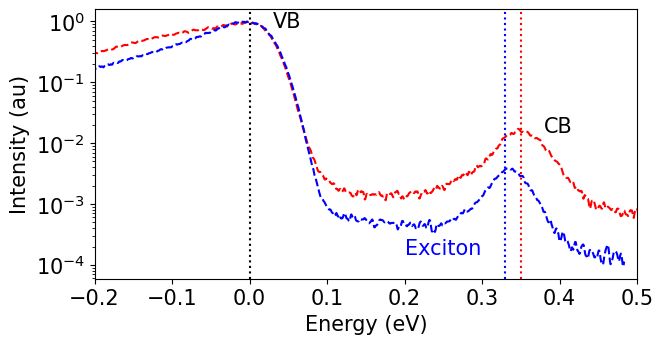

In [38]:

plt.figure(figsize=(7, 3.5))

plt.plot(EDC_3000[0,:],EDC_3000[1,:],'--',color='red')
plt.plot(EDC_4000[0,:],EDC_4000[1,:],'--',color='blue')

plt.text(0.03,0.8,'VB',fontsize=15)
plt.text(0.38,0.015,'CB',fontsize=15)
plt.text(0.2,0.00015,'Exciton',color='blue',fontsize=15)
plt.yscale('log')
plt.xlim(-0.2,0.5)
plt.axvline(x=0,color='black',linestyle=':')
plt.axvline(x=0.33,color='blue',linestyle=':')
plt.axvline(x=0.35,color='red',linestyle=':')

plt.tick_params(axis='x', labelsize=15)
plt.xlabel('Energy (eV)',fontsize=15)

plt.tick_params(axis='y', labelsize=15)
plt.ylabel('Intensity (au)',fontsize=15)

print(np.where(EDC_3000[1,:] == np.max(EDC_3000[1,:]))[0] ,EDC_3000[0, np.where(EDC_3000[1,:] == np.max(EDC_3000[1,:]))[0] ] -0.05  )

plt.savefig("Plots_EDC/"+"Experimental_EDC.png",bbox_inches='tight', transparent=False)
plt.savefig("Plots_EDC/"+"Experimental_EDC.pdf",bbox_inches='tight', transparent=True)

(300, 150)
(300, 150)
(300, 150)
(300, 150)
(300, 150)


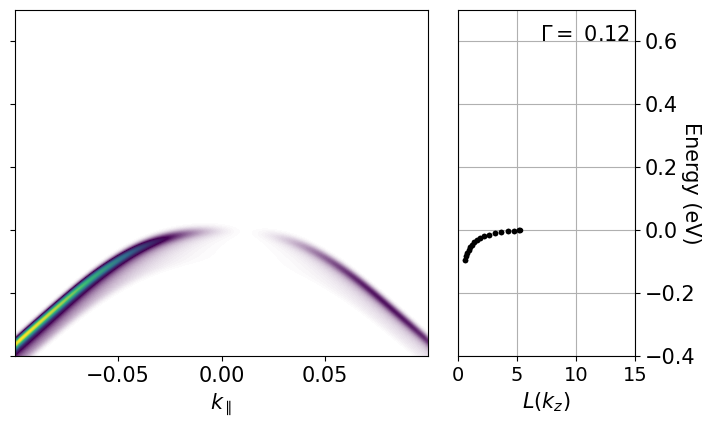

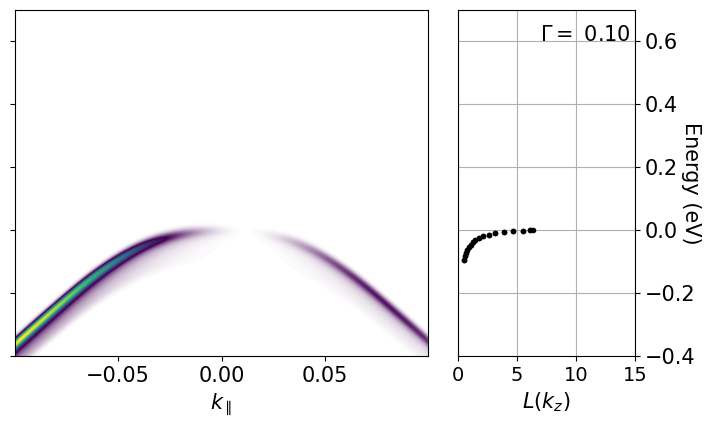

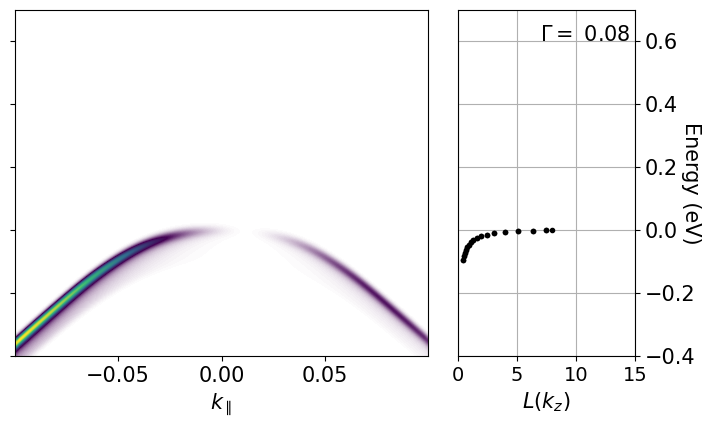

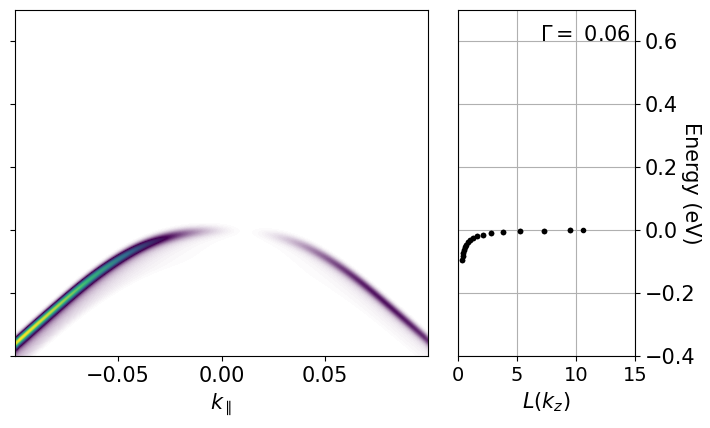

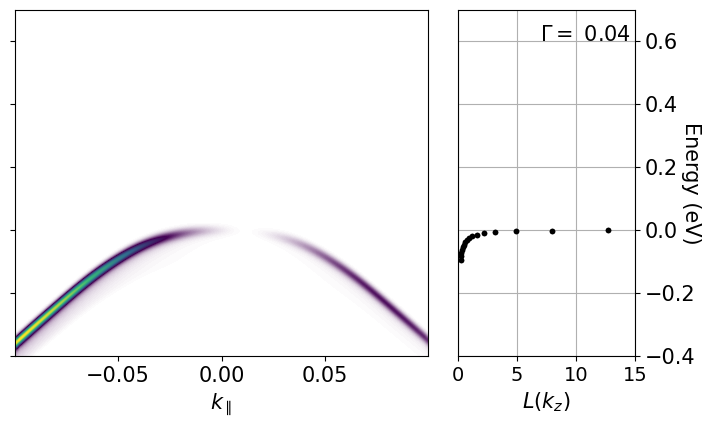

In [29]:
for ancho in np.array([0.12,0.1,0.08,0.06,0.04]):

    Intensity_V  = np.zeros((len(kz_smearing),len(EnergySpectrum),n_kpts))

    for i in range(len(kz_smearing)):
        for ω_ii in range(len(EnergySpectrum)):
            for kk in range(np.shape(Ev_kpts)[-1]):#*abs(mel_pol_p[1,kk,ω_ii])**2
                Intensity_V[i,ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_z_kpts[i,kk], tolerancia)\
                    *abs(mel_pol_p[0,kk,ω_ii])**2 *Lorentz_smearing(kz_smearing[i],ancho)
    
    
    IntensityV_plot = 1/(len(kz_smearing))*np.sum(Intensity_V,axis=0)
    print(np.shape(IntensityV_plot))
    #IntensityV_plot  = Intensity_V[:,:].reshape(len(EnergySpectrum),n_kpts)[:,:]
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4.5), gridspec_kw={'width_ratios': [3.5, 1.5]})
    
    
    cbarticks = np.arange(0.0,np.max(np.abs(IntensityV_plot)),1)
    
    a = axes[0].imshow(np.abs(IntensityV_plot),vmin=0,vmax=np.max(np.abs(IntensityV_plot)),\
               extent=[x_kpts.min(),x_kpts.max(),\
                       cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
                origin='lower',aspect='auto',interpolation ='spline36',cmap = cmap_arpes3())
                #origin='lower',aspect='auto',interpolation ='spline36',cmap = 'afmhot_r')
    
    for i,z_repetitions in enumerate(kz_smearing):
        plt.plot(Lorentz_smearing(z_repetitions,ancho),np.max(Ev_z_kpts[i]*cst.Ry),'.',color='black')
        if i ==0:
            axes[1].text(7,0.6,f"$\\Gamma =$ {ancho:.2f}",fontsize=15)
        


    axes[0].set_yticklabels([])
    #axes[1].plot(EnergySpectrum*cst.Ry,np.abs(Intensity[:,95]),':')
    axes[1].set_ylim(wmin * cst.Ry,wmax * cst.Ry)
    axes[1].set_xlim(0,15)
    axes[1].set_ylabel(r"Energy (eV)", rotation=-90,fontsize=15)
    axes[1].set_xlabel(r"$L(k_z)$",fontsize=15)
    axes[1].yaxis.tick_right()
    axes[1].yaxis.set_label_position("right")
    axes[1].tick_params(axis='y', labelsize=15)
    axes[1].tick_params(axis='x', labelsize=14)
    
    axes[1].grid()
    
    plt.subplots_adjust(wspace=0.1)
    
    axes[0].set_ylim(wmin * cst.Ry,wmax * cst.Ry)
    axes[0].set_xlim(-.1,0.1)
    axes[0].set_xlabel(r"$k_{\parallel}$",fontsize=15)
    axes[0].tick_params(axis='x', labelsize=15)    
    axes[0].set_xticks([-0.05,0.0,0.05])

    plt.savefig("./K_z_smearing/" + f"Lorentzian_smearing_Γ={ancho:.2f}.png",bbox_inches='tight', transparent=False)
    plt.savefig("./K_z_smearing/" + f"Lorentzian_smearing_Γ={ancho:.2f}.pdf",bbox_inches='tight', transparent=True)

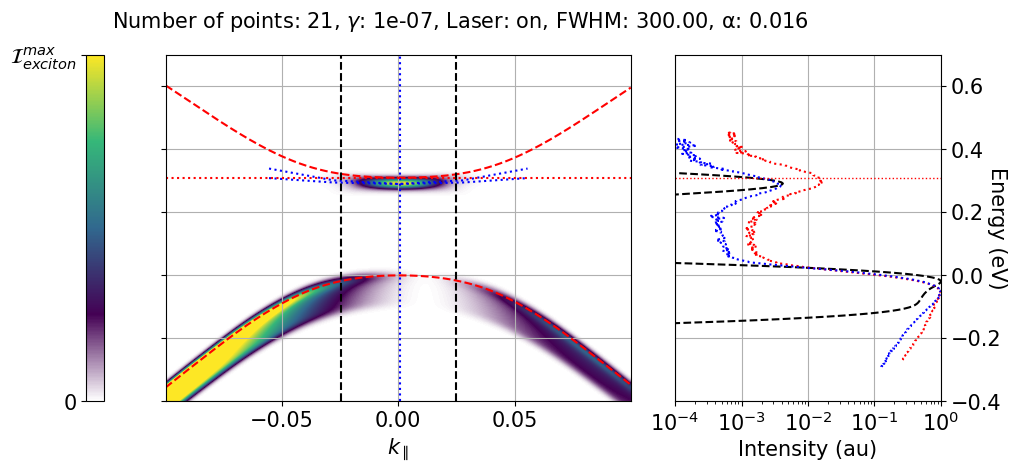

In [52]:
"""Intensity_V  = np.zeros((len(EnergySpectrum),n_kpts))
for ω_ii in range(len(EnergySpectrum)):
    for kk in range(np.shape(Ev_kpts)[-1]):#*abs(mel_pol_p[1,kk,ω_ii])**2
        Intensity_V[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia)\
            *abs(mel_pol_p[0,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])
        
IntensityV_plot  = Intensity_V[:,:].reshape(len(EnergySpectrum),n_kpts)[:,:]
"""

Intensity_V  = np.zeros((len(kz_smearing),len(EnergySpectrum),n_kpts))

for i in range(len(kz_smearing)):
    for ω_ii in range(len(EnergySpectrum)):
        for kk in range(np.shape(Ev_kpts)[-1]):#*abs(mel_pol_p[1,kk,ω_ii])**2
            Intensity_V[i,ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_z_kpts[i,kk], tolerancia)\
                *abs(mel_pol_p[0,kk,ω_ii])**2 *Lorentz_smearing(kz_smearing[i],ancho)


IntensityV_plot = np.sum(Intensity_V,axis=0) *1/sum(Lorentz_smearing(kz_smearing,ancho))#(len(kz_smearing))

Intensity_E  = np.zeros((nq**3,len(EnergySpectrum),n_kpts))

for ω_ii in range(len(EnergySpectrum)):
    for kk in range(np.shape(Ev_kpts)[-1]):#*abs(mel_pol_p[1,kk,ω_ii])**2
        Intensity_E[:,ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_Qpts_n[:,kk]- ϵ_total_n[:], tolerancia)\
            *abs(Ψ_kpts_n[:,kk])            *average_positions[maximos[:]] *abs(mel_pol_p[1,kk,ω_ii])**2

IntensityE_plot =np.zeros((len(EnergySpectrum),n_kpts))
for qq_ii in range(nq**3):
#    Funcion_Particion += Incoherent.partition_weight(ϵ_total_n[qq_ii],β)/Incoherent.partition_weight(ϵ_total_0,β)
    IntensityE_plot += Intensity_E[qq_ii,:,:].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]


#IntensityE_plot*=1/Funcion_Particion
#factor=np.max(IntensityV_plot)/np.max(IntensityE_plot) 

Intensity = IntensityE_plot + IntensityV_plot


k_start = -0.025  # Start of the range
k_end = 0.025    # End of the range


mask = (x_kpts >= k_start) & (x_kpts <= k_end)


#integral = np.trapz(Intensity[:,mask], x_kpts[mask])

integral  = np.sum(Intensity[:,mask], axis=1)
integral *= 1/(np.sum(mask))

IntensityE_plot[mask_Energy] *=1000

Intensity = IntensityE_plot + IntensityV_plot

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), gridspec_kw={'width_ratios': [3.5, 1.5]})

if switch == 'on':
    plt.suptitle(f'Number of points: {nq}, $\\gamma$: {γ_i}, Laser: {switch}, FWHM: {FWHM}, α: {α}', fontsize=15)
else:
    plt.suptitle(f'Number of points: {nq}, $\\gamma$: {γ_i}, Laser: {switch}', fontsize=15)

cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

a = axes[0].imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
           extent=[x_kpts.min(),x_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
            origin='lower',aspect='auto',interpolation ='spline36',cmap = cmap_arpes3())
            #origin='lower',aspect='auto',interpolation ='spline36',cmap = 'afmhot_r')

cbar = fig.colorbar(a, ax=axes[0],ticks=[0, np.max(np.abs(IntensityE_plot)) ], location='left')
cbar.ax.set_yticklabels([0, r'$\mathcal{I}_{exciton}^{max}$'],fontsize=15)



axes[0].plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_x-0.007218415494380028),':',color='blue' )
axes[0].plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_y-0.007218415494380028),':',color='blue' )
#ax1.plot(x_kpts, cst.Ry *(Ev_Qpts + ϵ_total),':',color='blue')
#ax1.plot(x_kpts, cst.Ry *Ev_Qpts,':',color='blue')
axes[0].plot(x_kpts, cst.Ry *Ev_kpts,'--',color='red')
axes[0].plot(x_kpts, cst.Ry *(Ec_kpts),'--',color='red')
axes[0].set_ylim(wmin * cst.Ry,wmax * cst.Ry)
axes[0].set_xlim(-.1,0.1)
axes[0].set_xlabel(r"$k_{\parallel}$",fontsize=15)

axes[0].set_xticks([-0.05,0.0,0.05])

axes[0].tick_params(axis='x', labelsize=15)
axes[0].axvline(x=x_kpts[mask][0],linestyle='--',color='black')
axes[0].axvline(x=x_kpts[75],linestyle=':',color='blue')
axes[0].axvline(x=x_kpts[mask][-1],linestyle='--',color='black')
#axes[0].axvline(x=x_kpts[mask][0],linestyle=':',color='red')
#axes[0].axvline(x=x_kpts[mask][-1],linestyle=':',color='green')



axes[0].grid()


#axes[1].plot(np.abs(np.mean(Intensity[:, 55:95], axis=1)),EnergySpectrum*cst.Ry,color='black' )
#axes[1].plot(np.abs(Intensity[:,55]),EnergySpectrum*cst.Ry,':',color='blue')
#axes[1].plot(np.abs(Intensity[:,75]),EnergySpectrum*cst.Ry,'--',color='red')



#axes[1].plot(np.abs(Intensity[:,mask][:,0]),EnergySpectrum*cst.Ry,'--',color='red')    
#axes[1].plot(np.abs(Intensity[:,75]),EnergySpectrum*cst.Ry,':',color='blue')
axes[1].plot(integral/np.max(integral),EnergySpectrum*cst.Ry,'--',color='black')

axes[1].plot(EDC_3000[1,:],EDC_3000[0,:]-0.05,':',color='red')
axes[1].plot(EDC_4000[1,:],EDC_4000[0,:]-0.05,':',color='blue')

axes[1].set_xscale('log')
axes[1].set_ylabel(r"Energy (eV)", rotation=-90,fontsize=15)
axes[1].set_xlabel(r"Intensity (au)",fontsize=15)
axes[1].yaxis.set_label_position("right")
axes[1].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].yaxis.tick_right()
axes[1].set_xlim(0.0001, 1)
axes[1].axhline(y=np.min(cst.Ry *(Ec_kpts)),color="red",linestyle=':',linewidth=1.0)
axes[0].axhline(y=np.min(cst.Ry *(Ec_kpts)),color="red",linestyle=':',linewidth=1.5)
#axes[1].axvline(x=0.002,color="red",linestyle=':',linewidth=1.5)
#axes[1].axvline(x=0.5,color="red",linestyle=':',linewidth=1.5)

axes[0].set_yticklabels([])
#axes[1].plot(EnergySpectrum*cst.Ry,np.abs(Intensity[:,95]),':')
axes[1].set_ylim(wmin * cst.Ry,wmax * cst.Ry)
axes[1].grid()

plt.subplots_adjust(wspace=0.1)


plt.savefig("Plots_EDC/"+"Spectrum_nq="+str(nq)+"_γ="+str(γ_i)+"_laser="+switch+"_FWHM="+str(FWHM)+"_α="+str(α)+"z_smearing.png",bbox_inches='tight', transparent=False)
plt.savefig("Plots_EDC/"+"Spectrum_nq="+str(nq)+"_γ="+str(γ_i)+"_laser="+switch+"_FWHM="+str(FWHM)+"_α="+str(α)+"z_smearing.pdf",bbox_inches='tight', transparent=True)
plt.show()

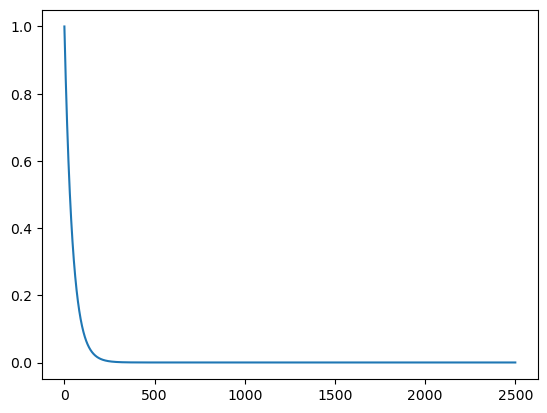

In [9]:
switch='off'
nq = 21
γ_i = 0.0000001
if switch=='off':
    fname = path_population + 'Boltzmann_Evolution_nq='+ str(nq)+ "_γ=" +str(γ_i)+"_laser="+str(switch)+ '.h5'

    
f = h5py.File(fname, "r")
Q_red     = np.array(f['Q_grid'])
Boltzmann = np.array(f['P_q(t)'])
time_evol = np.array(f['time'])

f.close()

plt.plot(time_evol,Boltzmann[0,:])

nsnap = 4
step = len(time_evol) // nsnap
dist = Boltzmann[:,::step]

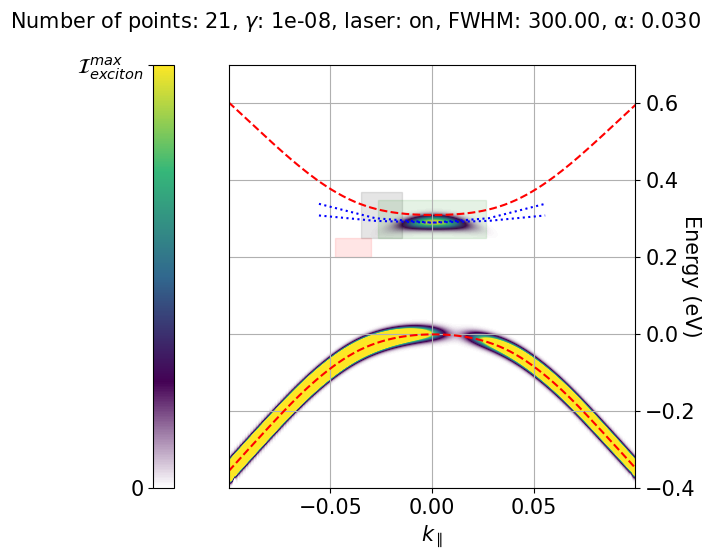

In [14]:
k_start = -0.030  # Start of the range
k_end   = -0.015   # End of the range

E_start = 0.20 +0.005# + 0.1 # Start of the range
E_end   = 0.25 +0.020# + 0.1 # End of the range




k_start_coh   = -0.04762593  # Start of the range
k_end_coh     = -0.030   # End of the range
k_start_incoh = -0.035  # Start of the range
k_end_incoh   = -0.015   # End of the range

k_start_tot   = -0.02645885  # Start of the range
k_end_tot     =  0.02645885   # End of the range



E_start_coh   = 0.20 -0.15*0 # Start of the range
E_end_coh     = 0.25 -0.15*0  # End of the range
E_start_incoh = 0.15 +0.00 + 0.1 # Start of the range
E_end_incoh   = 0.25 +0.020 + 0.1 # End of the range

E_start_tot   = 0.25 + 0.05*0   # Start of the range
E_end_tot     = 0.35 + 0.05*0  # End of the range




mask_k = (x_kpts >= k_start) & (x_kpts <= k_end)
mask_E = (cst.Ry * EnergySpectrum >= E_start) & (cst.Ry * EnergySpectrum <= E_end)

filtered_E = np.where(mask_E)[0] 
filtered_k = np.where(mask_k)[0]


Intensity_V  = np.zeros((len(EnergySpectrum),n_kpts))
for ω_ii in range(len(EnergySpectrum)):
    for kk in range(np.shape(Ev_kpts)[-1]):#*abs(mel_pol_p[1,kk,ω_ii])**2
        Intensity_V[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia)\
            *abs(mel_pol_p[0,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])
        
IntensityV_plot  = Intensity_V[:,:].reshape(len(EnergySpectrum),n_kpts)[:,:]


Intensity_E  = np.zeros((nq**3,len(EnergySpectrum),n_kpts))

for ω_ii in range(len(EnergySpectrum)):
    for kk in range(np.shape(Ev_kpts)[-1]):#*abs(mel_pol_p[1,kk,ω_ii])**2
        Intensity_E[:,ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_Qpts_n[:,kk]- ϵ_total_n[:], tolerancia)\
            *abs(Ψ_kpts_n[:,kk])            *dist[maximos[:],0] *abs(mel_pol_p[1,kk,ω_ii])**2

IntensityE_plot =np.zeros((len(EnergySpectrum),n_kpts))
for qq_ii in range(nq**3):
#    Funcion_Particion += Incoherent.partition_weight(ϵ_total_n[qq_ii],β)/Incoherent.partition_weight(ϵ_total_0,β)
    IntensityE_plot += Intensity_E[qq_ii,:,:].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]


#IntensityE_plot*=1/Funcion_Particion
#factor=np.max(IntensityV_plot)/np.max(IntensityE_plot) 

Intensity = IntensityE_plot + IntensityV_plot



#integral = np.trapz(Intensity[:,mask], x_kpts[mask])

integral  = np.sum(Intensity[:,mask_k], axis=1)
integral *= 1/(np.sum(mask_k))

#IntensityE_plot[mask_Energy] *=1000

Intensity = IntensityE_plot + IntensityV_plot

fig, axes = plt.subplots(1, figsize=(7, 5.5) )

if switch == 'on':
    plt.suptitle(f'Number of points: {nq}, $\\gamma$: {γ_i}, laser: {switch}, FWHM: {FWHM}, α: {α}', fontsize=15)
else:
    plt.suptitle(f'Number of points: {nq}, $\\gamma$: {γ_i}, laser: {switch}', fontsize=15)

cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

a = axes.imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
           extent=[x_kpts.min(),x_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
            origin='lower',aspect='auto',interpolation ='spline36',cmap = cmap_arpes3())
            #origin='lower',aspect='auto',interpolation ='spline36',cmap = 'afmhot_r')

cbar = fig.colorbar(a, ax=axes,ticks=[0, np.max(np.abs(IntensityE_plot)) ], location='left')
cbar.ax.set_yticklabels([0, r'$\mathcal{I}_{exciton}^{max}$'],fontsize=15)



axes.plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_x-0.007218415494380028),':',color='blue' )
axes.plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_y-0.007218415494380028),':',color='blue' )
#ax1.plot(x_kpts, cst.Ry *(Ev_Qpts + ϵ_total),':',color='blue')
#ax1.plot(x_kpts, cst.Ry *Ev_Qpts,':',color='blue')
axes.plot(x_kpts, cst.Ry *Ev_kpts,'--',color='red')
axes.plot(x_kpts, cst.Ry *(Ec_kpts),'--',color='red')
axes.set_ylim(wmin * cst.Ry,wmax * cst.Ry)
axes.set_xlim(-.1,0.1)
axes.set_xlabel(r"$k_{\parallel}$",fontsize=15)

axes.set_xticks([-0.05,0.0,0.05])

axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
axes.yaxis.set_label_position("right")
axes.set_ylabel(r"Energy (eV)", rotation=-90,fontsize=15)
axes.yaxis.tick_right()

#axes.axhline(y = EnergySpectrum[ filtered_E[0]  ] * cst.Ry,linestyle=':',color='green')
#axes.axhline(y = EnergySpectrum[ filtered_E[-1] ] * cst.Ry,linestyle=':',color='green')

#axes.axvline(x = x_kpts[ filtered_k[0]  ],linestyle=':',color='green')
#axes.axvline(x = x_kpts[ filtered_k[-1] ],linestyle=':',color='green')


axes.grid()

#axes.add_patch(Rectangle((k_start, E_start), k_end-k_start, E_end -E_start, edgecolor='green',
#                    facecolor='green',
#                    alpha=0.1 ))


axes.add_patch(Rectangle((k_start_coh, E_start_coh), k_end_coh-k_start_coh, E_end_coh -E_start_coh, edgecolor='red',
                    facecolor='red',
                    alpha=0.1 ))

axes.add_patch(Rectangle((k_start_incoh, E_start_incoh), k_end_incoh-k_start_incoh, E_end_incoh -E_start_incoh, edgecolor='black',
                    facecolor='black',
                    alpha=0.1 ))

axes.add_patch(Rectangle((k_start_tot, E_start_tot), k_end_tot-k_start_tot, E_end_tot -E_start_tot, edgecolor='green',
                    facecolor='green',
                    alpha=0.1 ))

#axes.fill_betweenx(
#    y=[E_start * cst.Ry, E_end * cst.Ry],  # Set the y-range with Ry scaling
#    x1=k_start, x2=k_end,                  # Set the x-range
#    color='green', alpha=1.0
#)
#axes[1].plot(np.abs(np.mean(Intensity[:, 55:95], axis=1)),EnergySpectrum*cst.Ry,color='black' )
#axes[1].plot(np.abs(Intensity[:,55]),EnergySpectrum*cst.Ry,':',color='blue')
#axes[1].plot(np.abs(Intensity[:,75]),EnergySpectrum*cst.Ry,'--',color='red')



#axes[1].plot(np.abs(Intensity[:,mask][:,0]),EnergySpectrum*cst.Ry,'--',color='red')    
#axes[1].plot(np.abs(Intensity[:,75]),EnergySpectrum*cst.Ry,':',color='blue')
"""axes[1].plot(integral/np.max(integral)*0.5,EnergySpectrum*cst.Ry,'--',color='black')

axes[1].set_xscale('log')
axes[1].set_ylabel(r"Energy (eV)", rotation=-90,fontsize=15)
axes[1].yaxis.set_label_position("right")
axes[1].tick_params(axis='y', labelsize=15)
axes[1].yaxis.tick_right()
axes[1].set_xlim(0.0001, 1)

axes[0].set_yticklabels([])
#axes[1].plot(EnergySpectrum*cst.Ry,np.abs(Intensity[:,95]),':')
axes[1].set_ylim(wmin * cst.Ry,wmax * cst.Ry)
axes[1].grid()"""

#plt.savefig("Plots_Using_Boltzmann_Distribution/"+"Spectrum_nq="+str(nq)+"_tsnap="+str(tsnap)+"_γ="+str(γ)+"_laser="+switch+"_integral.png",bbox_inches='tight', transparent=False)
plt.show()

1e-08


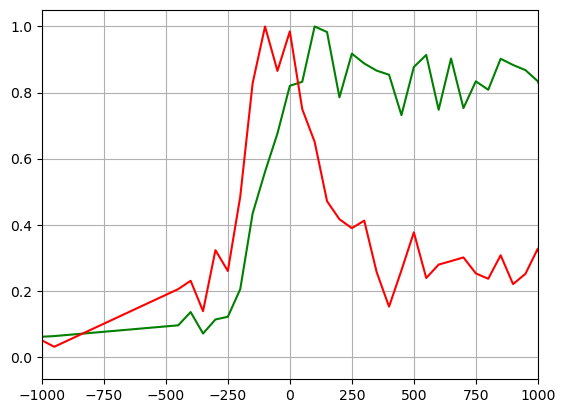

In [20]:
amplitud = 0.034
α = f"{amplitud:.3f}"

ancho = 300
FWHM = f"{ancho:.2f}"

switch='on'
nq = 21
γ_i = 0.00000001
print(γ_i)
ancho = 300
τ_0 = 4.5*ancho/(2.0*np.sqrt(2*np.log(2)))
if switch=='on':
    fname = path_population + 'Boltzmann_Evolution_nq='+ str(nq)+ "_γ=" +str(γ_i)+"_laser="+str(switch)+"_FWHM="+str(FWHM)+"_α="+str(α)+ '.h5'

    
f = h5py.File(fname, "r")
E_t       = np.array(f['E(t)'])
Q_red     = np.array(f['Q_grid'])
Boltzmann = np.array(f['P_q(t)'])
time_evol = np.array(f['time'])

f.close()

#nsnap = 15
#step = len(time_evol) // nsnap
#dist = Boltzmann[:,::step]

#------------------------Experimental Data---------------------------------------------
path_experiments = "./../../DATA/data_experiments/"
data_trace_incoh = np.loadtxt(path_experiments+'Data_trace_Incoherent_4000nm.txt').T
data_trace_coh   = np.loadtxt(path_experiments+'Data_trace_Coherent_4000nm.txt').T
time_trace = np.loadtxt(path_experiments+'Time4000nm.txt').T

plt.plot(time_trace[1,:],data_trace_incoh[1,:],'-',color='green')
plt.plot(time_trace[1,:],(data_trace_coh[1,:]+0.2)/max(data_trace_coh[1,:]+0.2),'-',color='red')

plt.xlim(-1000,1000)
plt.grid()

In [24]:
"""k_start_coh   = -0.030  # Start of the range
k_end_coh     = -0.015   # End of the range
k_start_incoh = -0.030  # Start of the range
k_end_incoh   = -0.015   # End of the range
"""
#E_start_coh   = 0.20 +0.005  # Start of the range
#E_end_coh     = 0.25 +0.020  # End of the range
#E_start_incoh = 0.20 +0.005 + 0.1 # Start of the range
#E_end_incoh   = 0.25 +0.020 + 0.1 # End of the range

k_start_coh   = -0.035 + 0.005- 0.010*0  # Start of the range
k_end_coh     = -0.015   # End of the range
k_start_incoh = -0.035  # Start of the range
k_end_incoh   = -0.015   # End of the range

k_start_tot   = -0.02645885  # Start of the range
k_end_tot     =  0.02645885   # End of the range



E_start_coh   = 0.20 -0.15*0  # Start of the range
E_end_coh     = 0.25 -0.15*0 # End of the range

E_start_coh   = 0.205  # Start of the range
E_end_coh     = 0.270  # End of the range

E_start_incoh = 0.15 +0.00 + 0.1 # Start of the range
E_end_incoh   = 0.25 +0.020 + 0.1 # End of the range

E_start_tot   = 0.26   # Start of the range
E_end_tot     = 0.34   # End of the range



mask_k_coh   = (x_kpts >= k_start_coh) & (x_kpts <= k_end_coh)
mask_E_coh   = (cst.Ry * EnergySpectrum >= E_start_coh) & (cst.Ry * EnergySpectrum <= E_end_coh)
mask_k_incoh = (x_kpts >= k_start_incoh) & (x_kpts <= k_end_incoh)
mask_E_incoh = (cst.Ry * EnergySpectrum >= E_start_incoh) & (cst.Ry * EnergySpectrum <= E_end_incoh)

mask_k_tot   = (x_kpts >= k_start_tot) & (x_kpts <= k_end_tot)
mask_E_tot   = (cst.Ry * EnergySpectrum >= E_start_tot) & (cst.Ry * EnergySpectrum <= E_end_tot)


filtered_E_coh   = np.where(mask_E_coh)[0] 
filtered_k_coh   = np.where(mask_k_coh)[0]
filtered_E_incoh = np.where(mask_E_incoh)[0] 
filtered_k_incoh = np.where(mask_k_incoh)[0]

filtered_E_tot   = np.where(mask_E_tot)[0] 
filtered_k_tot   = np.where(mask_k_tot)[0]



nsnap = 20
step = len(time_evol) // nsnap
dist = Boltzmann[:,::step]
#dist = Boltzmann[:,-10]

Intensity_V  = np.zeros((len(EnergySpectrum),n_kpts))
for ω_ii in range(len(EnergySpectrum)):
    for kk in range(np.shape(Ev_kpts)[-1]):#*abs(mel_pol_p[1,kk,ω_ii])**2
        Intensity_V[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia)\
            *abs(mel_pol_p[0,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])
        
IntensityV_plot  = Intensity_V[:,:].reshape(len(EnergySpectrum),n_kpts)[:,:]


Integral_coherent   = np.zeros(nsnap)
Integral_incoherent = np.zeros(nsnap)
Integral_total      = np.zeros(nsnap)
for tsnap in range(nsnap):
    Intensity_E  = np.zeros((nq**3,len(EnergySpectrum),n_kpts))

    for ω_ii in range(len(EnergySpectrum)):
        for kk in range(np.shape(Ev_kpts)[-1]):#*abs(mel_pol_p[1,kk,ω_ii])**2
            Intensity_E[:,ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_Qpts_n[:,kk]- ϵ_total_n[:], tolerancia)\
                *abs(Ψ_kpts_n[:,kk])            *dist[maximos[:],tsnap] *abs(mel_pol_p[1,kk,ω_ii])**2
                

    IntensityE_plot =np.zeros((len(EnergySpectrum),n_kpts))
    for qq_ii in range(nq**3):
    #    Funcion_Particion += Incoherent.partition_weight(ϵ_total_n[qq_ii],β)/Incoherent.partition_weight(ϵ_total_0,β)
        IntensityE_plot += Intensity_E[qq_ii,:,:].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]

    
    #IntensityE_plot*=1/Funcion_Particion
    #factor=np.max(IntensityV_plot)/np.max(IntensityE_plot) 
    
    Intensity = IntensityE_plot + IntensityV_plot
    
    
    Integral_coherent[tsnap]   = np.sum(Intensity[filtered_E_coh  ,:][:,filtered_k_coh  ])
    Integral_incoherent[tsnap] = np.sum(Intensity[filtered_E_incoh,:][:,filtered_k_incoh])
    Integral_total[tsnap]      = np.sum(Intensity[filtered_E_tot  ,:][:,filtered_k_tot  ])
    #plt.plot(Integral)
    print(Integral_coherent[tsnap])

    """fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), gridspec_kw={'width_ratios': [3.5, 1.5]})
    
    if switch == 'on':
        plt.suptitle(f'Number of points: {nq}, $\\gamma$: {γ_i}, laser: {switch}, FWHM: {FWHM}, α: {α}', fontsize=15)
    else:
        plt.suptitle(f'Number of points: {nq}, $\\gamma$: {γ_i}, laser: {switch}', fontsize=15)

    cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

    a = axes[0].imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
               extent=[x_kpts.min(),x_kpts.max(),\
                       cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
                origin='lower',aspect='auto',interpolation ='spline36',cmap = cmap_arpes3())
                #origin='lower',aspect='auto',interpolation ='spline36',cmap = 'afmhot_r')

    cbar = fig.colorbar(a, ax=axes[0],ticks=[0, np.max(np.abs(IntensityE_plot)) ], location='left')
    cbar.ax.set_yticklabels([0, r'$\mathcal{I}_{exciton}^{max}$'],fontsize=15)

    axes[0].add_patch(Rectangle((k_start_coh, E_start_coh), k_end_coh-k_start_coh, E_end_coh -E_start_coh, edgecolor='red',
                    facecolor='red',
                    alpha=0.1 ))

    axes[0].plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_x-0.007218415494380028),':',color='blue' )
    axes[0].plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_y-0.007218415494380028),':',color='blue' )
    #ax1.plot(x_kpts, cst.Ry *(Ev_Qpts + ϵ_total),':',color='blue')
    #ax1.plot(x_kpts, cst.Ry *Ev_Qpts,':',color='blue')
    axes[0].plot(x_kpts, cst.Ry *Ev_kpts,'--',color='red')
    axes[0].plot(x_kpts, cst.Ry *(Ec_kpts),'--',color='red')
    axes[0].set_ylim(wmin * cst.Ry,wmax * cst.Ry)
    axes[0].set_xlim(-.1,0.1)
    axes[0].set_xlabel(r"$k_{\parallel}$",fontsize=15)
    
    axes[0].set_xticks([-0.05,0.0,0.05])
    
    axes[0].tick_params(axis='x', labelsize=15)
    #axes[0].axvline(x=x_kpts[mask][0],linestyle='--',color='black')
    axes[0].axvline(x=x_kpts[75],linestyle=':',color='blue')
    #axes[0].axvline(x=x_kpts[mask][-1],linestyle='--',color='black')
    #axes[0].axvline(x=x_kpts[mask][0],linestyle=':',color='red')
    #axes[0].axvline(x=x_kpts[mask][-1],linestyle=':',color='green')
    axes[0].grid()
    
    #axes[1].plot(Integral_coherent/np.max(Integral_coherent),EnergySpectrum*cst.Ry,'--',color='black')
    
    axes[1].set_xscale('log')
    axes[1].set_ylabel(r"Energy (eV)", rotation=-90,fontsize=15)
    axes[1].yaxis.set_label_position("right")
    axes[1].tick_params(axis='y', labelsize=15)
    axes[1].yaxis.tick_right()
    axes[1].set_xlim(0.001, 1)
    
    axes[0].set_yticklabels([])
    #axes[1].plot(EnergySpectrum*cst.Ry,np.abs(Intensity[:,95]),':')
    axes[1].set_ylim(wmin * cst.Ry,wmax * cst.Ry)
    axes[1].grid()
    
    plt.subplots_adjust(wspace=0.1)
    
    
    #plt.savefig("Plots_Using_Boltzmann_Distribution/"+"Spectrum_nq="+str(nq)+"_tsnap="+str(tsnap)+"_γ="+str(γ)+"_laser="+switch+"_integral.png",bbox_inches='tight', transparent=False)
    plt.show()""";

<>:98: SyntaxWarning: invalid escape sequence '\m'
<>:98: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7844/992550370.py:98: SyntaxWarning: invalid escape sequence '\m'
  """fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), gridspec_kw={'width_ratios': [3.5, 1.5]})


9.194170667783646e-81
2.746571842779507
55.1265609052693
57.48845290000561
50.80804239054903
46.323988520531486
43.40847522801242
41.53059562416888
40.31761777462131
39.52590675127667
39.001304342207305
38.64753018646733
38.40453894282482
38.23463286017018
38.11386046278102
38.02675781317791
37.96315192603769
37.91621910667242
37.88129971003304
37.855136661846686


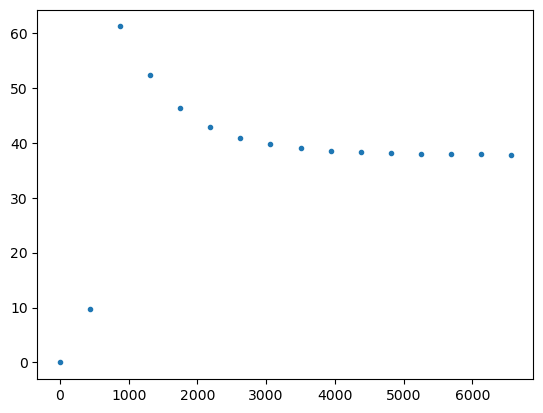

In [23]:
plt.plot(time_evol[::step],Integral_coherent,'.')

ValueError: x and y must have same first dimension, but have shapes (16,) and (15,)

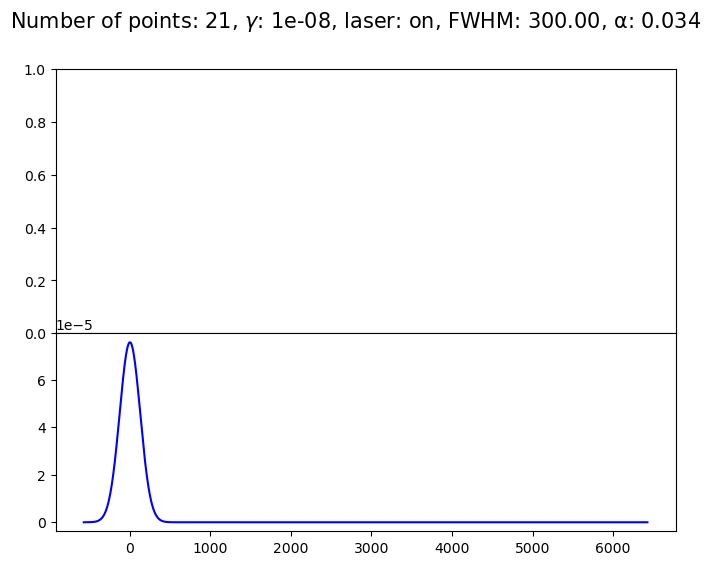

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [2, 1.5]})

plt.suptitle(f'Number of points: {nq}, $\\gamma$: {γ_i}, laser: {switch}, FWHM: {FWHM}, α: {α}', fontsize=15)

ax2.plot(time_evol- τ_0, E_t, color='blue',linestyle='-')
ax1.plot(time_evol[::step]- τ_0,Integral_coherent/max(Integral_coherent),'o',color='red')
#ax1.plot(time_evol[::step]- τ_0,Integral_incoherent/max(Integral_incoherent),'o',color='black')

#ax1.plot(time_evol[::step] - τ_0,Integral_total/max(Integral_total),'o',color='green')
ax1.set_xlim(-1000,6000)


ax1.plot(time_trace[1,:],data_trace_incoh[1,:],':',color='green')
ax1.plot(time_trace[1,:],(data_trace_coh[1,:]+0.2)/max(data_trace_coh[1,:]+0.2),':',color='red')


#ax1.axvline(x = τ_0,color='blue',linestyle=':')
#ax2.axvline(x = τ_0,color='blue',linestyle=':')
#ax2.set_ylim(-0.001,0.012)
#ax2.axhline(y=0.01,color='black',linestyle='--')
ax2.set_xlabel("Time (fs)",fontsize=15)
ax1.set_ylabel("Intensity",fontsize=15)
ax2.tick_params(axis="x", labelsize=15)
ax2.tick_params(axis="y", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
ax2.set_ylabel("$E_{env} (t)$",fontsize=15)

ax1_secondary = ax1.twinx()  # Create a twin y-axis sharing the same x-axis
ax1_secondary.plot(time_evol - τ_0, Boltzmann[0,:], color = 'blue',linestyle='--', label="Second Data")
ax1_secondary.set_ylabel("$P_{q=0}(t)$", fontsize=15, color='blue')  # Change the label for the second y-axis
ax1_secondary.tick_params(axis="y", labelsize=15, labelcolor='blue')  # Set y-axis tick color to red
#ax1_secondary.axhline(y=amplitud,color='red',linestyle='--')

ax2.spines['left'].set_visible(True)    # Show the left spine
ax2.spines['bottom'].set_visible(True)  # Show the bottom spine
ax2.spines['right'].set_visible(False)  # Hide the right spine
ax2.spines['top'].set_visible(True)  # Hide the right spine
ax1.spines['left'].set_visible(True)    # Show the left spine
ax1.spines['bottom'].set_visible(False)  # Show the bottom spine
ax1.spines['right'].set_visible(False)  # Hide the right spine
ax1.spines['top'].set_visible(False)  # Hide the right spine

ax1_secondary.spines['left'].set_visible(True)    # Show the left spine
ax1_secondary.spines['bottom'].set_visible(False)  # Show the bottom spine
ax1_secondary.spines['right'].set_visible(True)  # Hide the right spine
ax1_secondary.spines['top'].set_visible(False)  # Hide the right spine

ax2.spines['left'].set_linewidth(1.5)
ax2.spines['top'].set_linewidth(0.5)
ax2.spines['bottom'].set_linewidth(1.5)
ax1.spines['left'].set_linewidth(1.5)
ax1_secondary.spines['right'].set_linewidth(1.5)
ax2.spines['top'].set_linestyle(':')

ax1.grid()


#if switch == 'on':
#    plt.savefig("Plots_Populations/"+"Coherent_laser="+switch+"_FWHM="+str(FWHM)+"_γ="+str(γ_i)+"_α="+str(α)+"_kmin="+str(k_start)+"_kmax="+str(k_end)+"_Emin="+str(f"{E_start:.3f}")+"_Emax="+str(f"{E_end:.3f}") +".png",bbox_inches='tight', transparent=False)


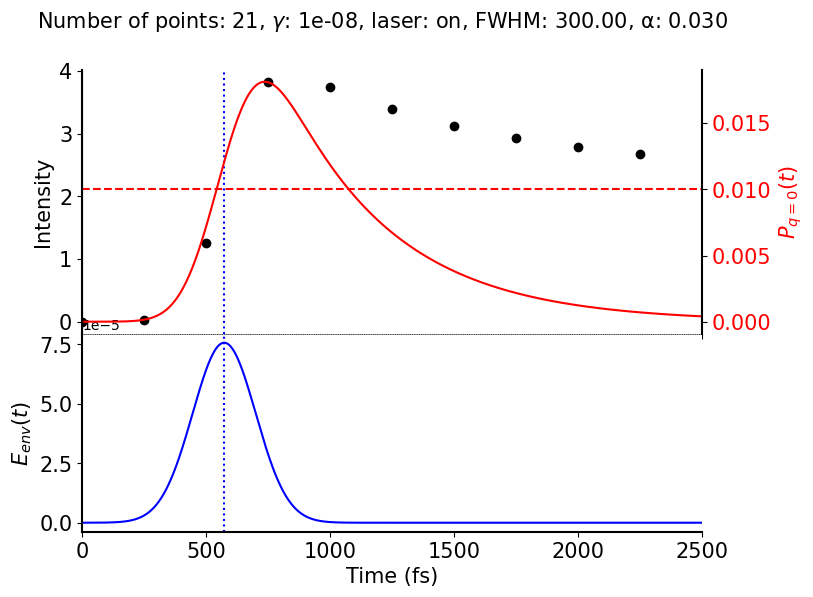

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [2, 1.5]})

plt.suptitle(f'Number of points: {nq}, $\\gamma$: {γ_i}, laser: {switch}, FWHM: {FWHM}, α: {α}', fontsize=15)

ax2.plot(time_evol, E_t, color='blue',linestyle='-')
ax1.plot(time_evol[::step],Integral,'o',color='black')
ax2.set_xlim(0,2500)


ax1.axvline(x = τ_0,color='blue',linestyle=':')
ax2.axvline(x = τ_0,color='blue',linestyle=':')
#ax2.set_ylim(-0.001,0.012)
#ax2.axhline(y=0.01,color='black',linestyle='--')
ax2.set_xlabel("Time (fs)",fontsize=15)
ax1.set_ylabel("Intensity",fontsize=15)
ax2.tick_params(axis="x", labelsize=15)
ax2.tick_params(axis="y", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
ax2.set_ylabel("$E_{env} (t)$",fontsize=15)

ax1_secondary = ax1.twinx()  # Create a twin y-axis sharing the same x-axis
ax1_secondary.plot(time_evol, Boltzmann[0,:], 'r-', label="Second Data")
ax1_secondary.set_ylabel("$P_{q=0}(t)$", fontsize=15, color='red')  # Change the label for the second y-axis
ax1_secondary.tick_params(axis="y", labelsize=15, labelcolor='red')  # Set y-axis tick color to red
ax1_secondary.axhline(y=0.01,color='red',linestyle='--')

ax2.spines['left'].set_visible(True)    # Show the left spine
ax2.spines['bottom'].set_visible(True)  # Show the bottom spine
ax2.spines['right'].set_visible(False)  # Hide the right spine
ax2.spines['top'].set_visible(True)  # Hide the right spine
ax1.spines['left'].set_visible(True)    # Show the left spine
ax1.spines['bottom'].set_visible(False)  # Show the bottom spine
ax1.spines['right'].set_visible(False)  # Hide the right spine
ax1.spines['top'].set_visible(False)  # Hide the right spine

ax1_secondary.spines['left'].set_visible(True)    # Show the left spine
ax1_secondary.spines['bottom'].set_visible(False)  # Show the bottom spine
ax1_secondary.spines['right'].set_visible(True)  # Hide the right spine
ax1_secondary.spines['top'].set_visible(False)  # Hide the right spine

ax2.spines['left'].set_linewidth(1.5)
ax2.spines['top'].set_linewidth(0.5)
ax2.spines['bottom'].set_linewidth(1.5)
ax1.spines['left'].set_linewidth(1.5)
ax1_secondary.spines['right'].set_linewidth(1.5)
ax2.spines['top'].set_linestyle(':')

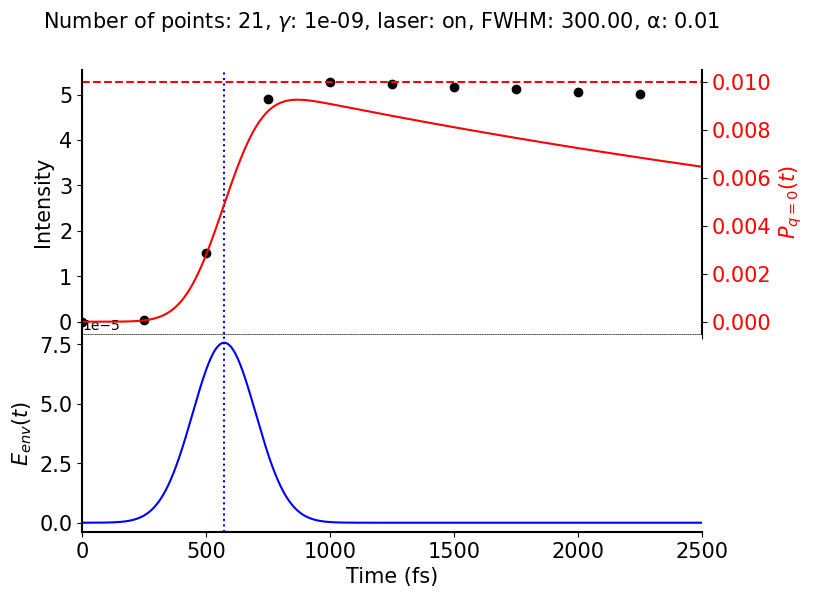

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [2, 1.5]})

plt.suptitle(f'Number of points: {nq}, $\\gamma$: {γ_i}, laser: {switch}, FWHM: {FWHM}, α: {α}', fontsize=15)

ax2.plot(time_evol, E_t, color='blue',linestyle='-')
ax1.plot(time_evol[::step],Integral,'o',color='black')
ax2.set_xlim(0,2500)


ax1.axvline(x = τ_0,color='blue',linestyle=':')
ax2.axvline(x = τ_0,color='blue',linestyle=':')
#ax2.set_ylim(-0.001,0.012)
#ax2.axhline(y=0.01,color='black',linestyle='--')
ax2.set_xlabel("Time (fs)",fontsize=15)
ax1.set_ylabel("Intensity",fontsize=15)
ax2.tick_params(axis="x", labelsize=15)
ax2.tick_params(axis="y", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
ax2.set_ylabel("$E_{env} (t)$",fontsize=15)

ax1_secondary = ax1.twinx()  # Create a twin y-axis sharing the same x-axis
ax1_secondary.plot(time_evol, Boltzmann[0,:], 'r-', label="Second Data")
ax1_secondary.set_ylabel("$P_{q=0}(t)$", fontsize=15, color='red')  # Change the label for the second y-axis
ax1_secondary.tick_params(axis="y", labelsize=15, labelcolor='red')  # Set y-axis tick color to red
ax1_secondary.axhline(y=0.01,color='red',linestyle='--')

ax2.spines['left'].set_visible(True)    # Show the left spine
ax2.spines['bottom'].set_visible(True)  # Show the bottom spine
ax2.spines['right'].set_visible(False)  # Hide the right spine
ax2.spines['top'].set_visible(True)  # Hide the right spine
ax1.spines['left'].set_visible(True)    # Show the left spine
ax1.spines['bottom'].set_visible(False)  # Show the bottom spine
ax1.spines['right'].set_visible(False)  # Hide the right spine
ax1.spines['top'].set_visible(False)  # Hide the right spine

ax1_secondary.spines['left'].set_visible(True)    # Show the left spine
ax1_secondary.spines['bottom'].set_visible(False)  # Show the bottom spine
ax1_secondary.spines['right'].set_visible(True)  # Hide the right spine
ax1_secondary.spines['top'].set_visible(False)  # Hide the right spine

ax2.spines['left'].set_linewidth(1.5)
ax2.spines['top'].set_linewidth(0.5)
ax2.spines['bottom'].set_linewidth(1.5)
ax1.spines['left'].set_linewidth(1.5)
ax1_secondary.spines['right'].set_linewidth(1.5)
ax2.spines['top'].set_linestyle(':')

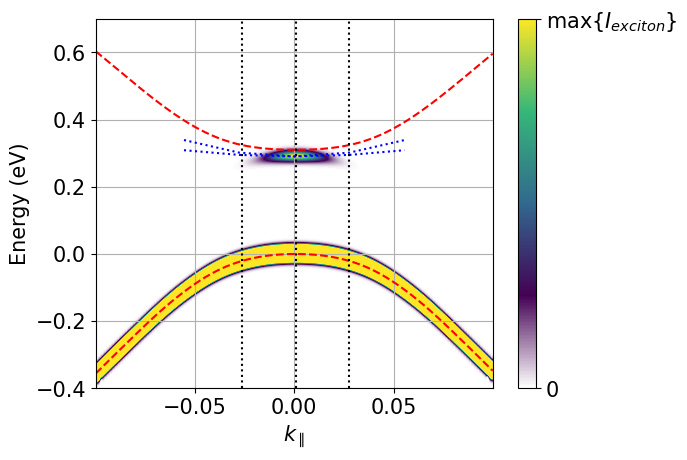

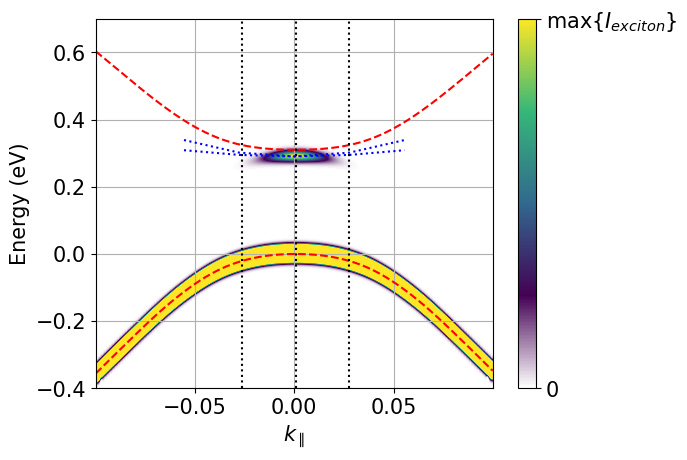

In [20]:
Intensity_V  = np.zeros((len(EnergySpectrum),n_kpts))
for ω_ii in range(len(EnergySpectrum)):
    for kk in range(np.shape(Ev_kpts)[-1]):#*abs(mel_pol_p[1,kk,ω_ii])**2
        Intensity_V[ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia)\
            #*abs(mel_pol_p[0,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])
        
IntensityV_plot  = Intensity_V[:,:].reshape(len(EnergySpectrum),n_kpts)[:,:]

for tsnap in range(nsnap*0,2):
    Intensity_E  = np.zeros((nq**3,len(EnergySpectrum),n_kpts))

    for ω_ii in range(len(EnergySpectrum)):
        for kk in range(np.shape(Ev_kpts)[-1]):#*abs(mel_pol_p[1,kk,ω_ii])**2
            Intensity_E[:,ω_ii,kk] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_Qpts_n[:,kk]- ϵ_total_n[:], tolerancia)\
                *abs(Ψ_kpts_n[:,kk])            *dist[maximos[:],0]

    IntensityE_plot =np.zeros((len(EnergySpectrum),n_kpts))
    for qq_ii in range(nq**3):
    #    Funcion_Particion += Incoherent.partition_weight(ϵ_total_n[qq_ii],β)/Incoherent.partition_weight(ϵ_total_0,β)
        IntensityE_plot += Intensity_E[qq_ii,:,:].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]

    
    #IntensityE_plot*=1/Funcion_Particion
    #factor=np.max(IntensityV_plot)/np.max(IntensityE_plot)




    Intensity = IntensityE_plot + IntensityV_plot

    fig, ax1 = plt.subplots()

    cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

    a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=np.max(np.abs(IntensityE_plot)),\
               extent=[x_kpts.min(),x_kpts.max(),\
                       cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
                origin='lower',aspect='auto',interpolation ='spline36',cmap = cmap_arpes3())
                #origin='lower',aspect='auto',interpolation ='spline36',cmap = 'afmhot_r')

    cbar = fig.colorbar(a, ax=ax1,ticks=[0, np.max(np.abs(IntensityE_plot)) ])
    cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)



    ax1.plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_x-0.007218415494380028),':',color='blue' )
    ax1.plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_y-0.007218415494380028),':',color='blue' )
    #ax1.plot(x_kpts, cst.Ry *(Ev_Qpts + ϵ_total),':',color='blue')
    #ax1.plot(x_kpts, cst.Ry *Ev_Qpts,':',color='blue')
    ax1.plot(x_kpts, cst.Ry *Ev_kpts,'--',color='red')
    ax1.plot(x_kpts, cst.Ry *(Ec_kpts),'--',color='red')
    ax1.set_ylim(wmin * cst.Ry,wmax * cst.Ry)
    ax1.set_xlim(-.1,0.1)
    ax1.set_xlabel(r"$k_{\parallel}$",fontsize=15)
    ax1.set_ylabel(r"Energy (eV)",fontsize=15)
    ax1.set_xticks([-0.05,0.0,0.05])
    ax1.tick_params(axis='y', labelsize=15)
    ax1.tick_params(axis='x', labelsize=15)
    ax1.axvline(x=x_kpts[75],linestyle=':',color='black')
    ax1.axvline(x=x_kpts[55],linestyle=':',color='black')
    ax1.axvline(x=x_kpts[95],linestyle=':',color='black')
    plt.grid()
    
    
    #plt.savefig("Plots_Using_Boltzmann_Distribution/"+"Spectrum_nq="+str(nq)+"_tsnap="+str(tsnap)+"_γ="+str(γ)+".png",bbox_inches='tight', transparent=False)
    plt.show()

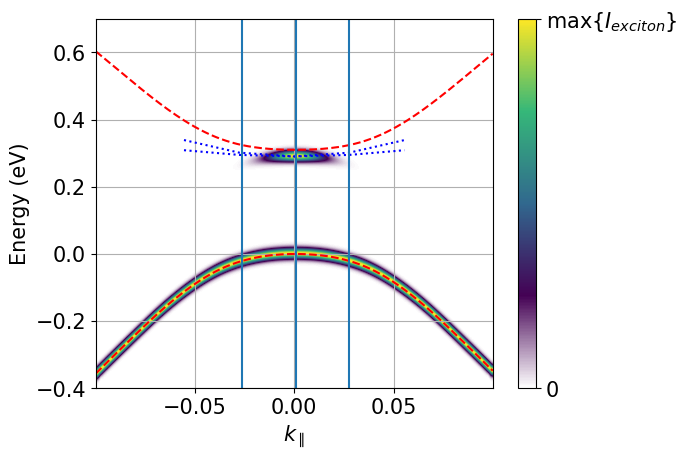

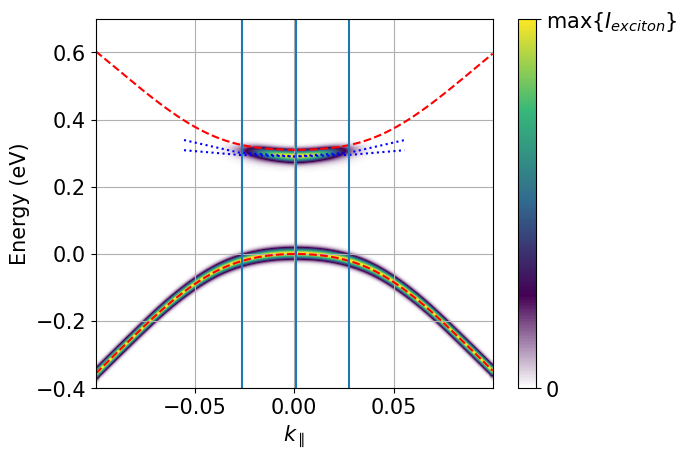

In [83]:
for tsnap in range(nsnap*0,2):
    Intensity_E  = np.zeros((nq**3,len(EnergySpectrum),n_kpts,3))

    for ω_ii in range(len(EnergySpectrum)):
        for kk in range(np.shape(Ev_kpts)[-1]):
            Intensity_E[:,ω_ii,kk,0] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_Qpts_n[:,kk]- ϵ_total_n[:], tolerancia)\
                *abs(Ψ_kpts_n[:,kk])*dist[maximos[:],tsnap]
                #*Incoherent.partition_weight(ϵ_total_n[:],β)/Incoherent.partition_weight(ϵ_total_0,β)

            Intensity_E[:,ω_ii,kk,1] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia)\
                #*abs(mel_pol_p[0,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])

            Intensity_E[:,ω_ii,kk,2] = Photo.Delta( EnergySpectrum[ω_ii]-Ec_kpts[kk], tolerancia)\
                #*abs(mel_pol_p[1,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])


    Funcion_Particion  = 0.0
    IntensityE_plot =np.zeros((len(EnergySpectrum),n_kpts))
    for qq_ii in range(nq**3):
        Funcion_Particion += Incoherent.partition_weight(ϵ_total_n[qq_ii],β)/Incoherent.partition_weight(ϵ_total_0,β)
        IntensityE_plot += Intensity_E[qq_ii,:,:,0].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]

    IntensityV_plot  = Intensity_E[0,:,:,1].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
    IntensityC_plot  = Intensity_E[0,:,:,2].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
    IntensityE_plot*=1/Funcion_Particion
    factor=np.max(IntensityV_plot)/np.max(IntensityE_plot)




    Intensity = IntensityE_plot*factor + IntensityV_plot + IntensityC_plot*0

    fig, ax1 = plt.subplots()

    cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

    a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=1*np.max(np.abs(Intensity)),\
               extent=[x_kpts.min(),x_kpts.max(),\
                       cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
                origin='lower',aspect='auto',interpolation ='spline36',cmap = cmap_arpes3())
                #origin='lower',aspect='auto',interpolation ='spline36',cmap = 'afmhot_r')

    cbar = fig.colorbar(a, ax=ax1,ticks=[0, 1*np.max(np.abs(Intensity)) ])
    cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)



    ax1.plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_x-0.007218415494380028),':',color='blue' )
    ax1.plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_y-0.007218415494380028),':',color='blue' )
    #ax1.plot(x_kpts, cst.Ry *(Ev_Qpts + ϵ_total),':',color='blue')
    #ax1.plot(x_kpts, cst.Ry *Ev_Qpts,':',color='blue')
    ax1.plot(x_kpts, cst.Ry *Ev_kpts,'--',color='red')
    ax1.plot(x_kpts, cst.Ry *(Ec_kpts),'--',color='red')
    ax1.set_ylim(wmin * cst.Ry,wmax * cst.Ry)
    ax1.set_xlim(-.1,0.1)
    ax1.set_xlabel(r"$k_{\parallel}$",fontsize=15)
    ax1.set_ylabel(r"Energy (eV)",fontsize=15)
    ax1.set_xticks([-0.05,0.0,0.05])
    ax1.tick_params(axis='y', labelsize=15)
    ax1.tick_params(axis='x', labelsize=15)
    ax1.axvline(x=x_kpts[75])
    ax1.axvline(x=x_kpts[55])
    ax1.axvline(x=x_kpts[95])
    plt.grid()
    
    
    #plt.savefig("Plots_Using_Boltzmann_Distribution/"+"Spectrum_nq="+str(nq)+"_tsnap="+str(tsnap)+"_γ="+str(γ)+".png",bbox_inches='tight', transparent=False)
    plt.show()

In [7]:
Intensity_E  = np.zeros((len(Q_grid),len(Q_grid),len(Q_grid),len(EnergySpectrum),n_kpts,3),dtype=np.float32)

for ω_ii in range(len(EnergySpectrum)):
    for kk in range(np.shape(Ev_kpts)[-1]):
        Intensity_E[:,:,:,ω_ii,kk,0] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_Qpts[:,:,:,kk]- ϵ_total[:,:,:], tolerancia)\
        *abs(mel_pol_s[1,kk,ω_ii])**2*abs(Ψ_kpts[:,:,:,kk])*Incoherent.partition_weight(ϵ_total,β)/Incoherent.partition_weight(ϵ_total_0,β)
        
        Intensity_E[:,:,:,ω_ii,kk,1] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia)\
        *abs(mel_pol_s[0,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])

        Intensity_E[:,:,:,ω_ii,kk,2] = Photo.Delta( EnergySpectrum[ω_ii]-Ec_kpts[kk], tolerancia)\
        *abs(mel_pol_s[1,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])

In [12]:
Intensity_E  = np.zeros((len(Q_grid),len(Q_grid),len(Q_grid),len(EnergySpectrum),n_kpts,3),dtype=np.float32)

for ω_ii in range(len(EnergySpectrum)):
    for kk in range(np.shape(Ev_kpts)[-1]):
        Intensity_E[:,:,:,ω_ii,kk,0] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_Qpts[:,:,:,kk]- ϵ_total[:,:,:], tolerancia)\
        *abs(mel_pol_s[1,kk,ω_ii])**2*abs(Ψ_kpts[:,:,:,kk])*Incoherent.partition_weight(ϵ_total,β)/Incoherent.partition_weight(ϵ_total_0,β)
        
        Intensity_E[:,:,:,ω_ii,kk,1] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia)\
        *abs(mel_pol_s[0,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])

        Intensity_E[:,:,:,ω_ii,kk,2] = Photo.Delta( EnergySpectrum[ω_ii]-Ec_kpts[kk], tolerancia)\
        *abs(mel_pol_s[1,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])

        
Funcion_Particion  = 0.0
IntensityE_plot =np.zeros((len(EnergySpectrum),n_kpts))
for qq_ii in range(len(Q_grid)):
    for qq_jj in range(len(Q_grid)):
        for qq_kk in range(len(Q_grid)):
            Funcion_Particion += Incoherent.partition_weight(ϵ_total[qq_ii,qq_jj,qq_kk],β)/Incoherent.partition_weight(ϵ_total_0,β)
            IntensityE_plot += Intensity_E[qq_ii,qq_jj,qq_kk,:,:,0].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]



IntensityV_plot  = Intensity_E[0,0,0,:,:,1].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
IntensityC_plot  = Intensity_E[0,0,0,:,:,2].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
IntensityE_plot*=1/Funcion_Particion
factor=np.max(IntensityV_plot)/np.max(IntensityE_plot)
#factor=20

Intensity = IntensityE_plot*factor + IntensityV_plot + IntensityC_plot*0

fig, ax1 = plt.subplots()

cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=1*np.max(np.abs(Intensity)),\
           extent=[x_kpts.min(),x_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
            origin='lower',aspect='auto',interpolation ='spline36',cmap = cmap_arpes3())
            #origin='lower',aspect='auto',interpolation ='spline36',cmap = 'afmhot_r')

cbar = fig.colorbar(a, ax=ax1,ticks=[0, 1*np.max(np.abs(Intensity)) ])
cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)



ax1.plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_x-0.007218415494380028),':',color='blue' )
ax1.plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_y-0.007218415494380028),':',color='blue' )
#ax1.plot(x_kpts, cst.Ry *(Ev_Qpts + ϵ_total),':',color='blue')
#ax1.plot(x_kpts, cst.Ry *Ev_Qpts,':',color='blue')
ax1.plot(x_kpts, cst.Ry *Ev_kpts,'--',color='red')
ax1.plot(x_kpts, cst.Ry *(Ec_kpts),'--',color='red')
ax1.set_ylim(wmin * cst.Ry,wmax * cst.Ry)
ax1.set_xlim(-.1,0.1)
ax1.set_xlabel(r"$k_{\parallel}$",fontsize=15)
ax1.set_ylabel(r"Energy (eV)",fontsize=15)
ax1.set_xticks([-0.05,0.0,0.05])
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)
plt.grid()

#plt.savefig("Spectrum_s_beta="+str(β)+".png",bbox_inches='tight', transparent=True)
#plt.savefig("Spectrum_s_beta="+str(β)+".pdf",bbox_inches='tight', transparent=True)

KeyboardInterrupt: 

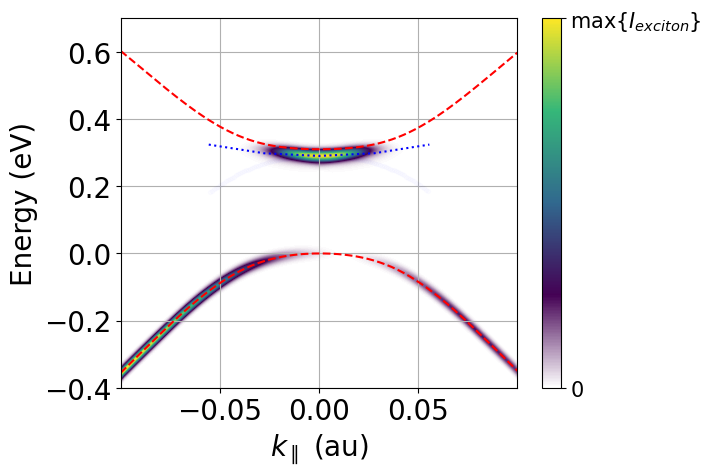

In [82]:
Intensity_E  = np.zeros((len(Q_grid),len(Q_grid),len(Q_grid),len(EnergySpectrum),n_kpts,3))

β=0.01

for ω_ii in range(len(EnergySpectrum)):
    for kk in range(np.shape(Ev_kpts)[-1]):
        Intensity_E[:,:,:,ω_ii,kk,0] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_Qpts[:,:,:,kk]- ϵ_total[:,:,:], tolerancia)\
        *abs(mel_pol_p[1,kk,ω_ii])**2*abs(Ψ_kpts[:,:,:,kk])*Incoherent.partition_weight(ϵ_total,β)/Incoherent.partition_weight(ϵ_total_0,β)
        
        Intensity_E[:,:,:,ω_ii,kk,1] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia)\
        *abs(mel_pol_p[0,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])

        Intensity_E[:,:,:,ω_ii,kk,2] = Photo.Delta( EnergySpectrum[ω_ii]-Ec_kpts[kk], tolerancia)\
        *abs(mel_pol_p[1,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])

Funcion_Particion  = 0.0
IntensityE_plot =np.zeros((len(EnergySpectrum),n_kpts))
for qq_ii in range(len(Q_grid)):
    for qq_jj in range(len(Q_grid)):
        for qq_kk in range(len(Q_grid)):
            Funcion_Particion += Incoherent.partition_weight(ϵ_total[qq_ii,qq_jj,qq_kk],β)/Incoherent.partition_weight(ϵ_total_0,β)
            IntensityE_plot += Intensity_E[qq_ii,qq_jj,qq_kk,:,:,0].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]


IntensityV_plot  = Intensity_E[0,0,0,:,:,1].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
IntensityC_plot  = Intensity_E[0,0,0,:,:,2].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
IntensityE_plot*=1/Funcion_Particion
factor=np.max(IntensityV_plot)/np.max(IntensityE_plot)
#factor=100000

Intensity = IntensityE_plot*factor + IntensityV_plot + IntensityC_plot*0

fig, ax1 = plt.subplots()

cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=1*np.max(np.abs(Intensity)),\
           extent=[x_kpts.min(),x_kpts.max(),\
                   cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
            origin='lower',aspect='auto',interpolation ='spline36',cmap = cmap_arpes3())
            #origin='lower',aspect='auto',interpolation ='spline36',cmap = 'afmhot_r')

cbar = fig.colorbar(a, ax=ax1,ticks=[0, 1*np.max(np.abs(Intensity)) ])
cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)


#ax1.axhline(y=0.31)
ax1.plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + (ϵ_x+ϵ_y)/2-0.007218415494380028),':',color='blue' )
#ax1.plot(x_kpts, cst.Ry *(Ev_Qpts + ϵ_total),':',color='blue')
#ax1.plot(x_kpts, cst.Ry *Ev_Qpts,':',color='blue')ϵ_parameters
ax1.plot(x_kpts[45:155], cst.Ry *(Ev_kpts[45:155]+ϵ_parameters[0]),'.',color='blue',alpha=0.01)
ax1.plot(x_kpts, cst.Ry *Ev_kpts,'--',color='red')
ax1.plot(x_kpts, cst.Ry *Ec_kpts,'--',color='red')
ax1.set_ylim(wmin * cst.Ry,wmax * cst.Ry)
ax1.set_xlim(-.1,0.1)
ax1.set_xlabel(r"$k_{\parallel}$ (au)",fontsize=20)
ax1.set_ylabel(r"Energy (eV)",fontsize=20)
ax1.set_xticks([-0.05,0.0,0.05])
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
plt.grid()

plt.savefig("Spectrum_p_beta="+str(β)+".png",bbox_inches='tight', transparent=True)
plt.savefig("Spectrum_p_beta="+str(β)+".pdf",bbox_inches='tight', transparent=True)

[0.58778525 0.         0.80901699] [0. 1. 0.]
1.5707963267948966 90.0


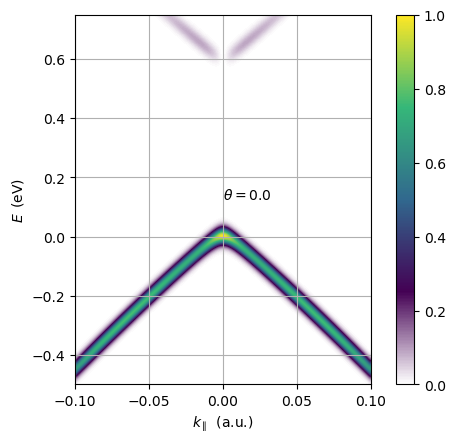

1.5707963267948966 90.0


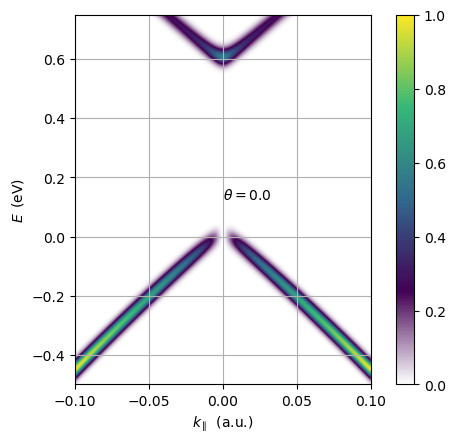

1.7453292519943295 100.0


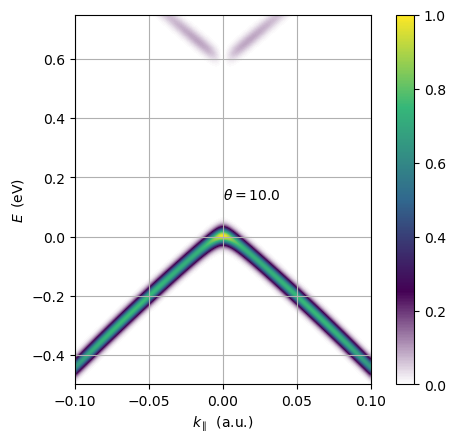

1.7453292519943295 100.0


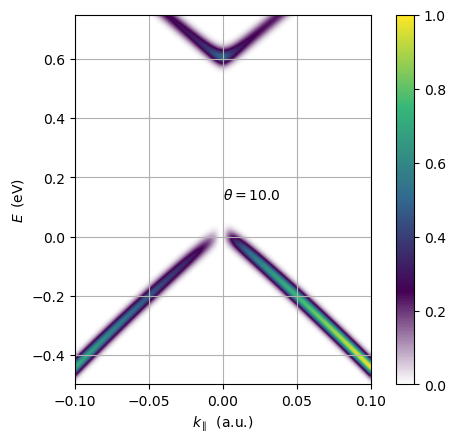

1.9198621771937625 110.0


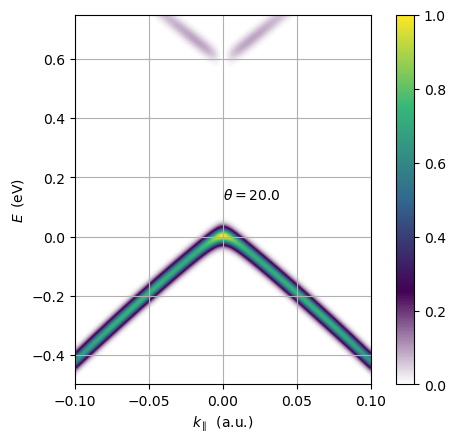

1.9198621771937625 110.0


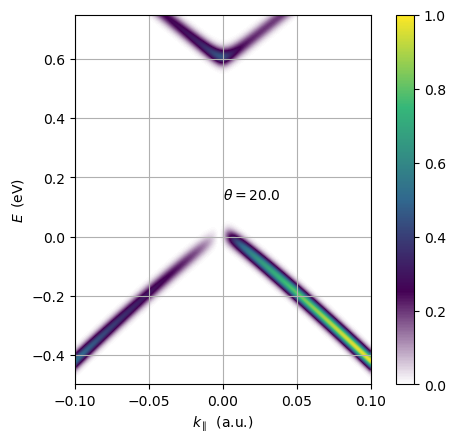

2.0943951023931953 119.99999999999999


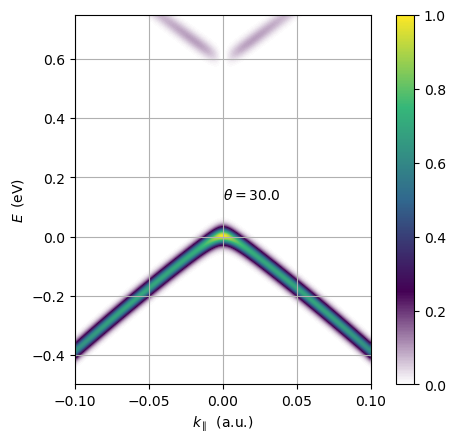

2.0943951023931953 119.99999999999999


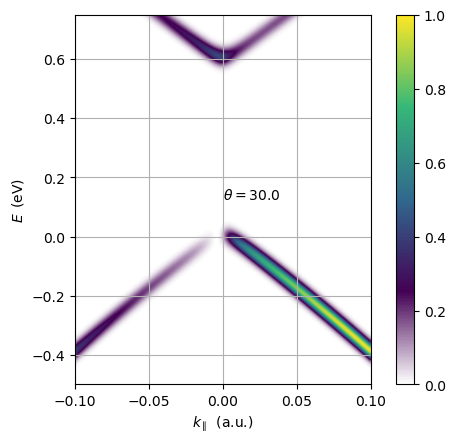

2.2689280275926285 130.0


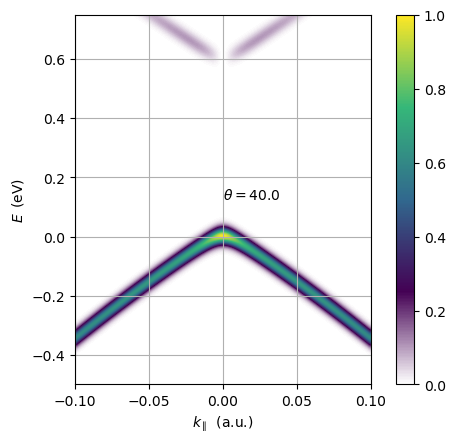

2.2689280275926285 130.0


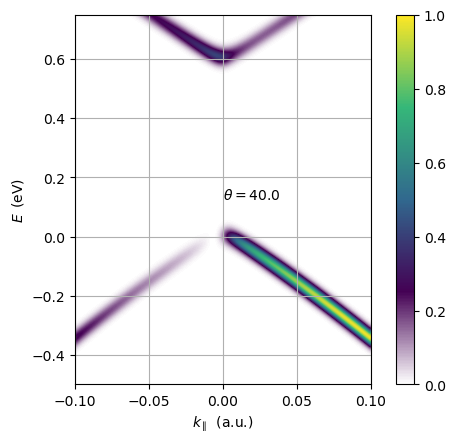

2.443460952792061 140.0


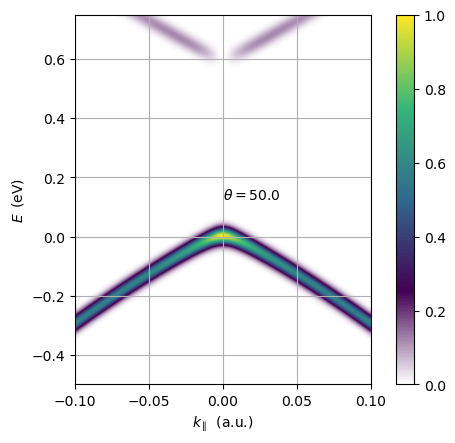

2.443460952792061 140.0


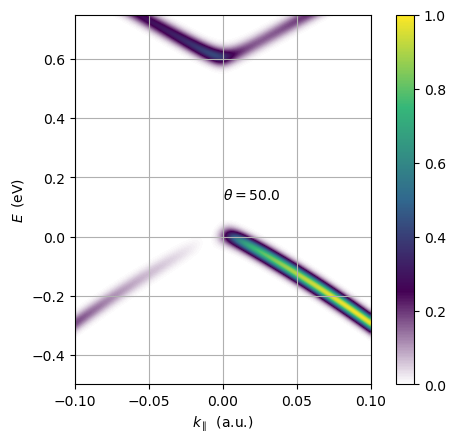

2.6179938779914944 150.00000000000003


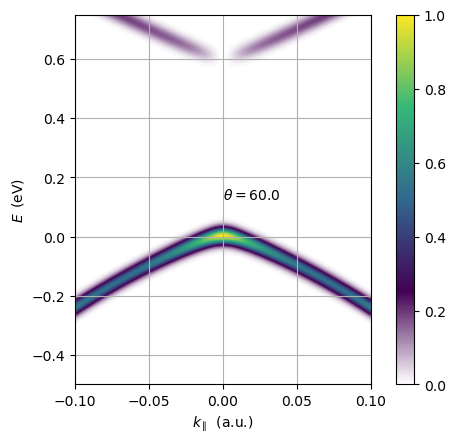

2.6179938779914944 150.00000000000003


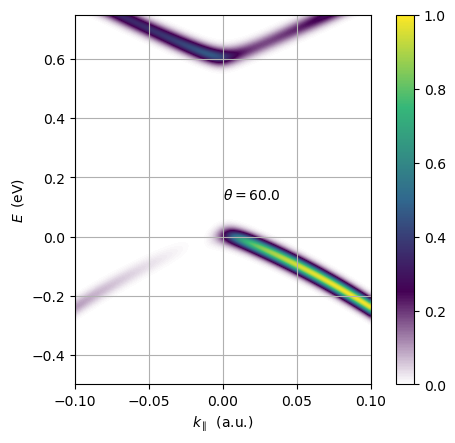

2.792526803190927 160.0


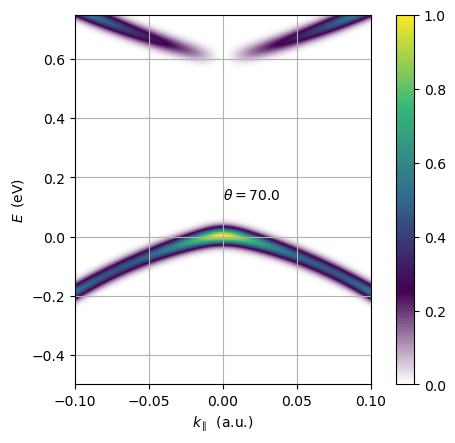

2.792526803190927 160.0


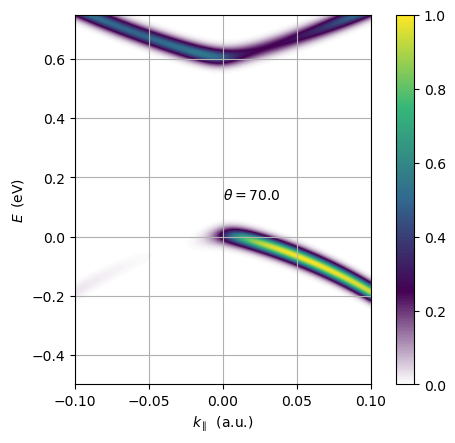

2.96705972839036 170.0


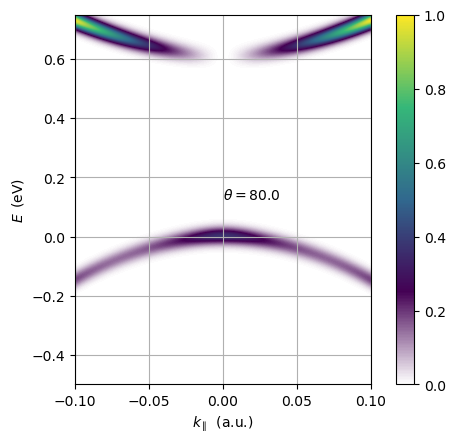

2.96705972839036 170.0


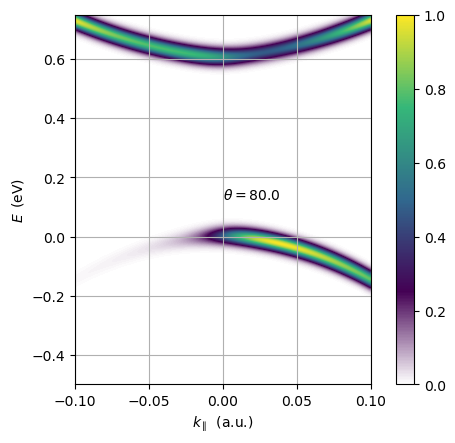

In [8]:
alpha = 54



photon = {
    'wphot': 6.2,
    'alpha': alpha,
    'Vin': 0.0,
    'Phiw': 4.95409,
    'Eshift': Eshift,
    'rint': [0.2, 1.0, 2.0],
    #'rint': [0.2, 3.8, 2.0],
    'eta': tolerancia
    #'eta': 0.0003
}

# probe
geo = LightGeometry(alpha/180. * np.pi, 0/180. * np.pi, 1.0)
pol_p = geo.GetPol_p_i()
pol_s = geo.GetPol_s_i()

print(pol_p,pol_s)

photon = {
    'wphot': 6.2,
    'alpha': alpha,
    'Vin': 0.0,
    'Phiw': 4.95409,
    'Eshift': Eshift,
    #'rint': [0.2, 1.0, 2.0],
    'rint': [4.2, 3.8, 2.0],
    #'eta': 0.002
    'eta': tolerancia
}



for aaaa in range(0,90,10):

    angulo=(aaaa+90)/180*np.pi
    
    geo = LightGeometry(alpha/180. * np.pi, aaaa/180. * np.pi, 1.0)
    pol_p = geo.GetPol_p_i()
    pol_s = geo.GetPol_s_i()
    
    kpath = {
        'nk': n_kpts,
        'kmin' :  -delta,
        'kmax' :   delta,
        'angulo': angulo
    }

    kpath['dir'] = 'dif'
    polarization = {'tag': 's', 'vector': pol_s}
    mel_pol_s = Incoherent_Fitting.GenMatrixElements(tipo_Hamiltoniano,vectores,EnergySpectrum,kpath,polarization,bands,bandas_info,photon)

    polarization = {'tag': 'p', 'vector': pol_p}
    mel_pol_p = Incoherent_Fitting.GenMatrixElements(tipo_Hamiltoniano,vectores,EnergySpectrum,kpath,polarization,bands,bandas_info,photon)


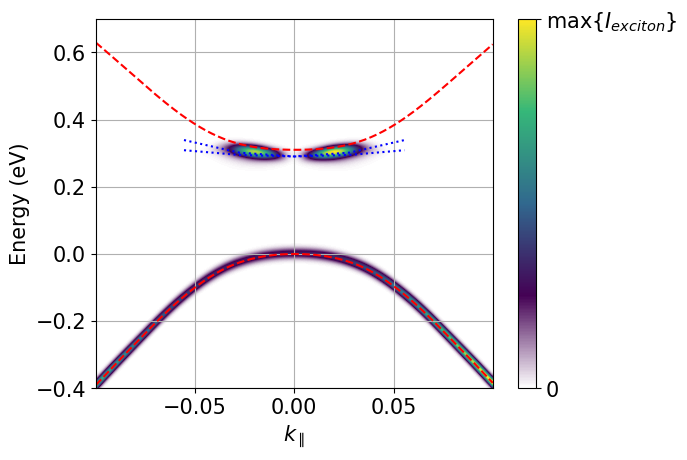

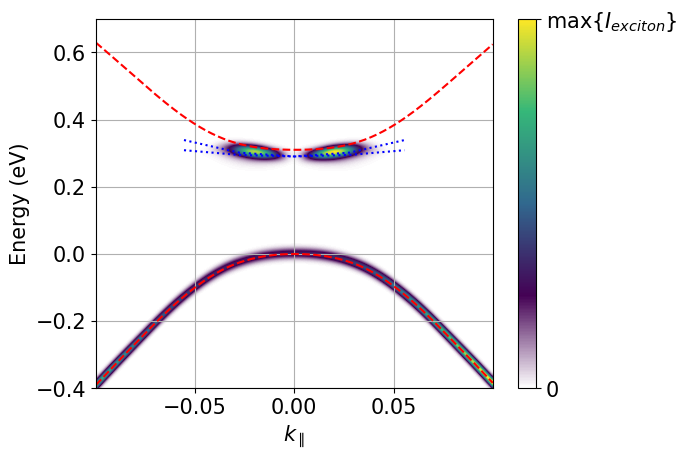

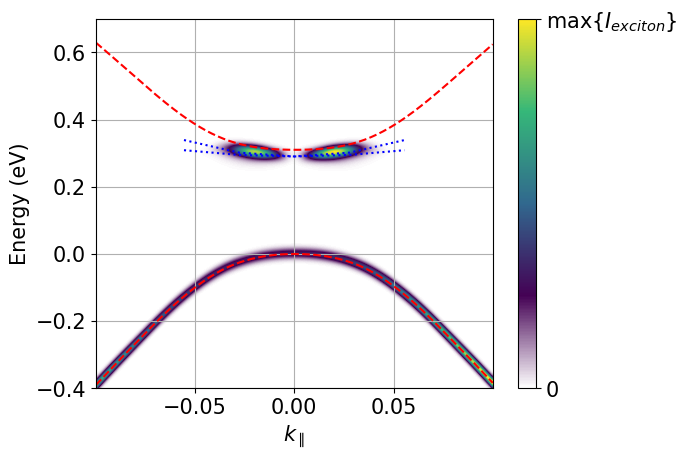

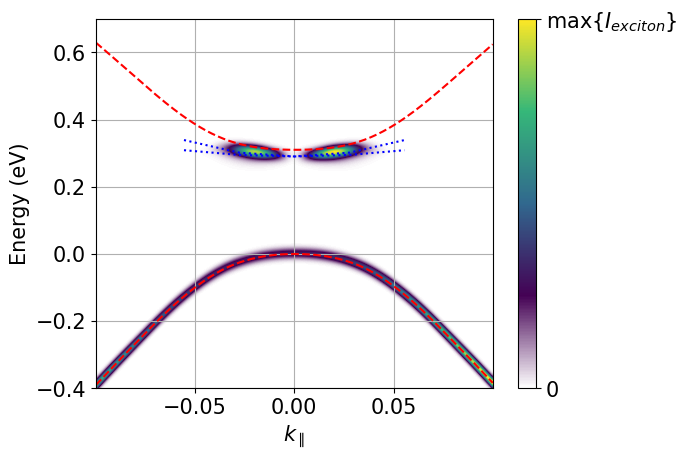

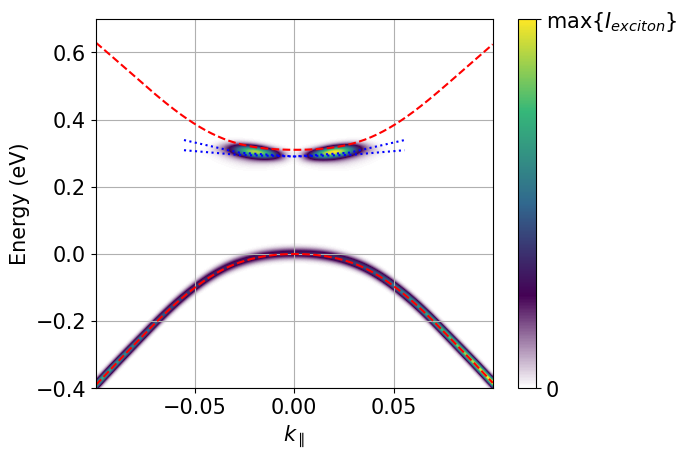

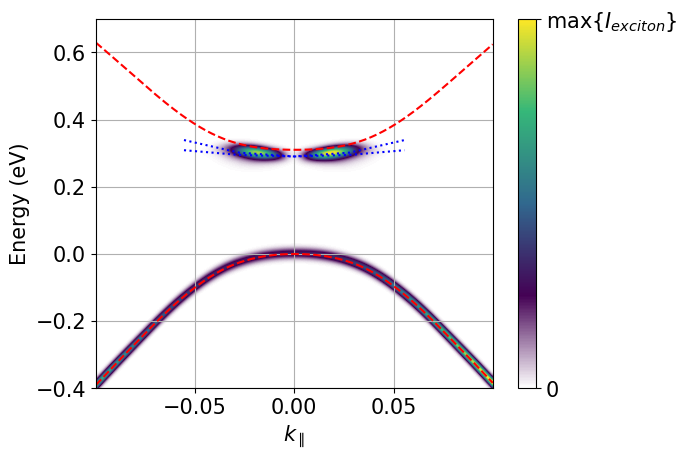

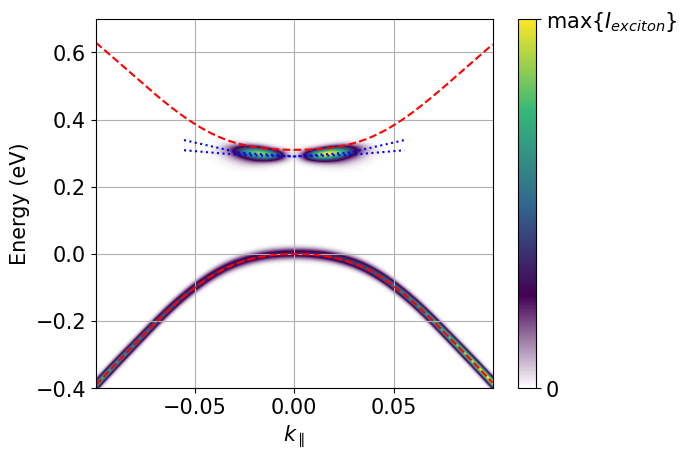

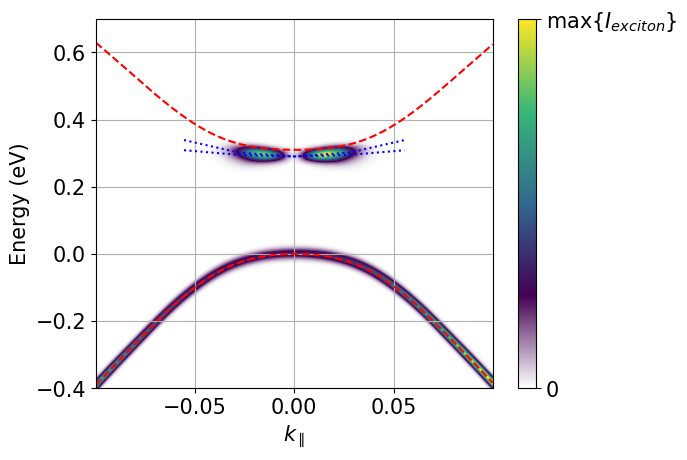

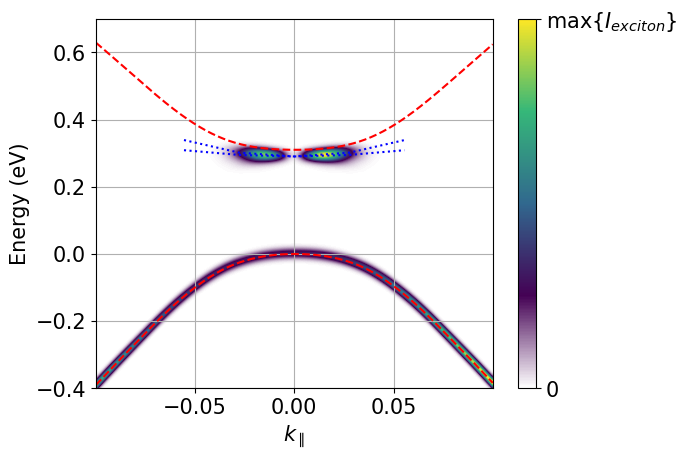

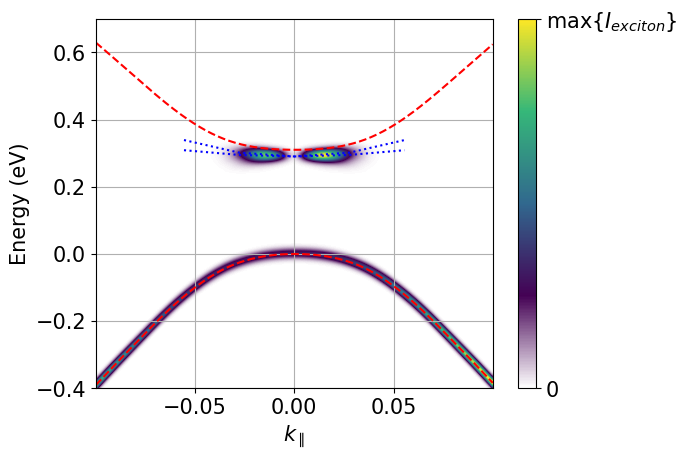

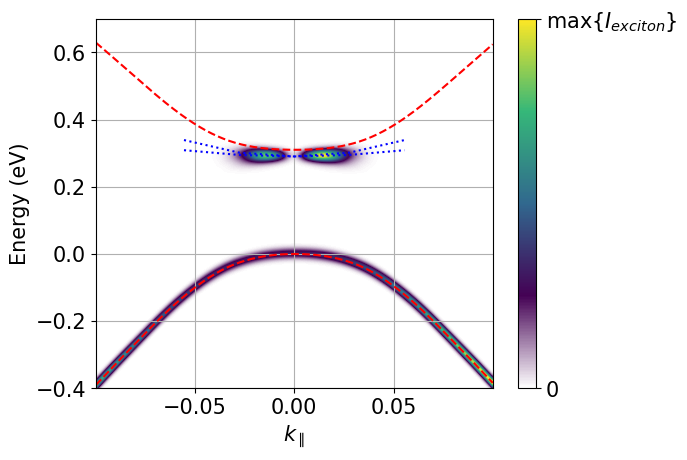

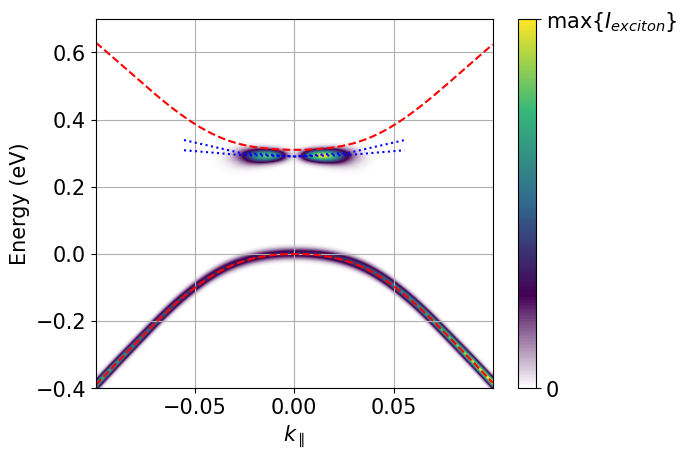

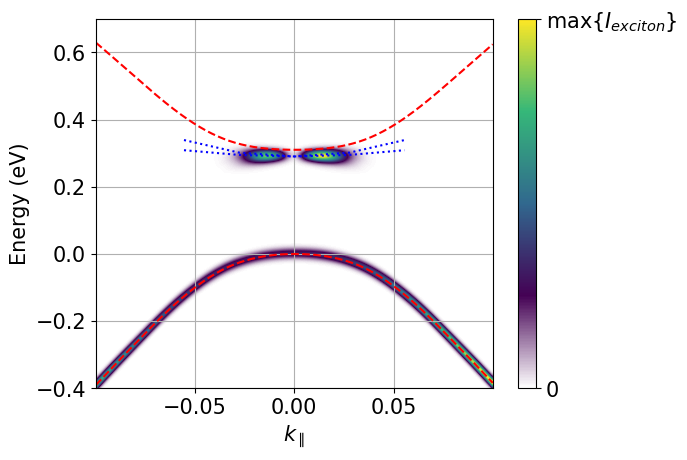

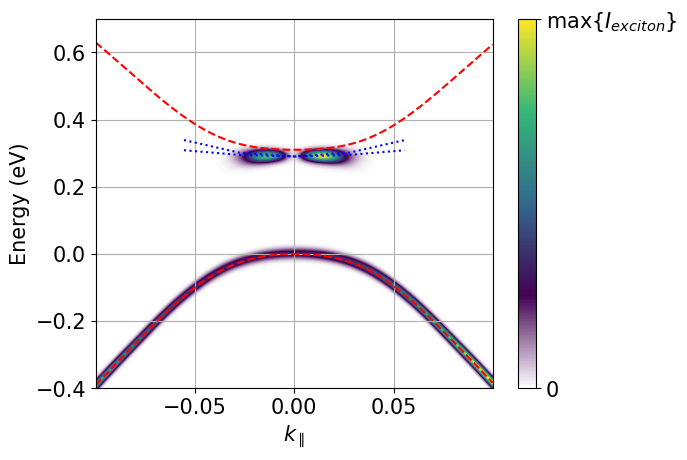

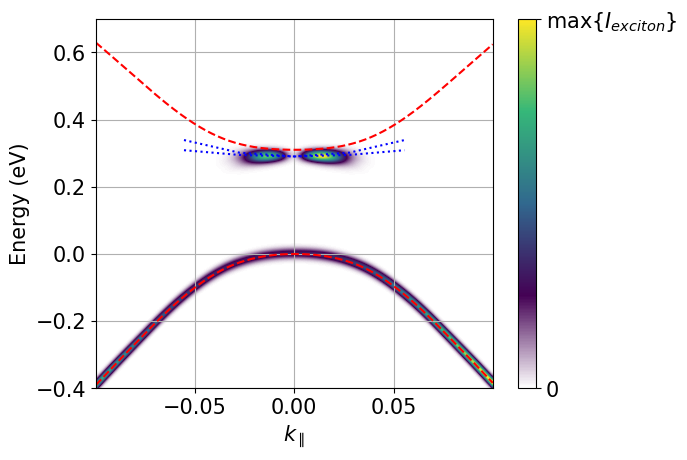

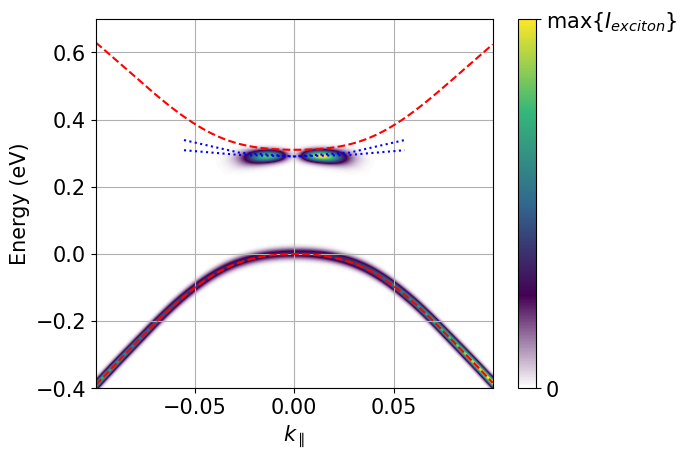

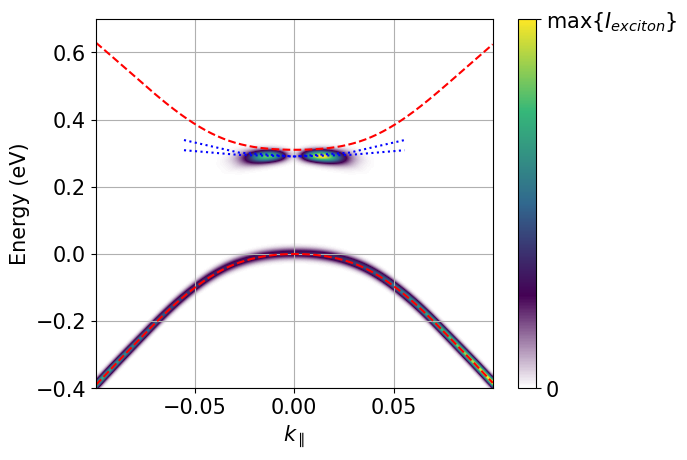

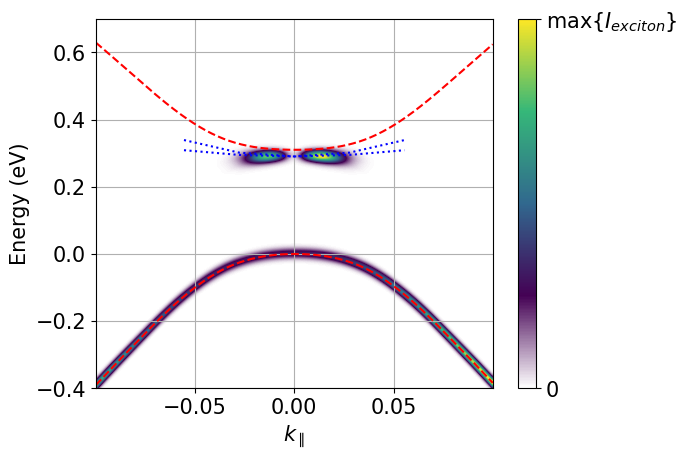

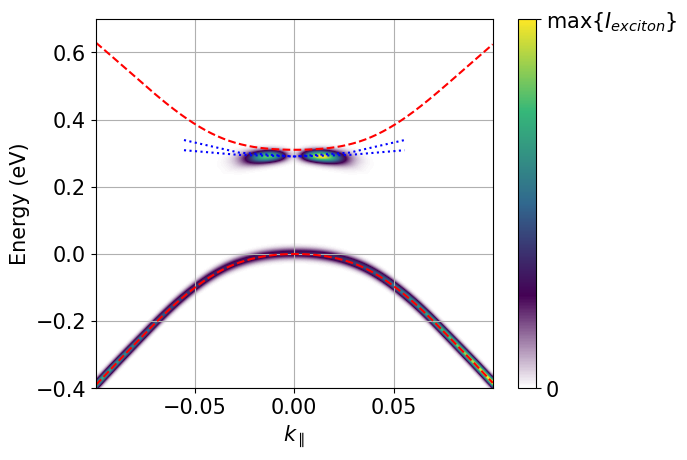

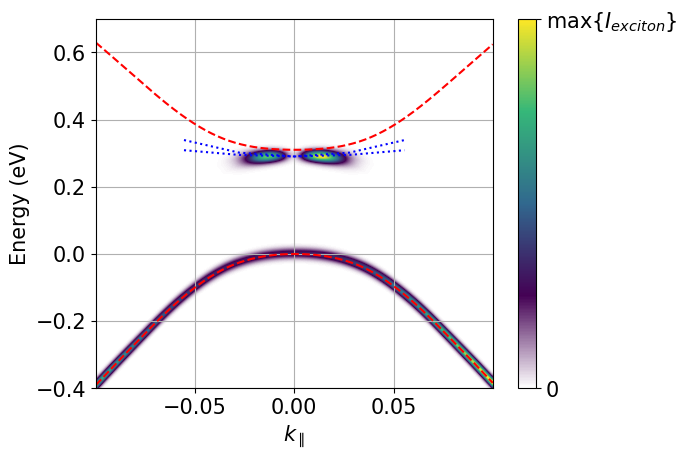

In [28]:
ββ = np.array([0.01,0.1,1.0,10,100,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000])

for β in ββ:

    Intensity_E  = np.zeros((len(Q_grid),len(Q_grid),len(Q_grid),len(EnergySpectrum),n_kpts,3))

    for ω_ii in range(len(EnergySpectrum)):
        for kk in range(np.shape(Ev_kpts)[-1]):
            Intensity_E[:,:,:,ω_ii,kk,0] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_Qpts[:,:,:,kk]- ϵ_total[:,:,:], tolerancia)\
            *abs(mel_pol_s[1,kk,ω_ii])**2*abs(Ψ_kpts[:,:,:,kk])*Incoherent.partition_weight(ϵ_total,β)/Incoherent.partition_weight(ϵ_total_0,β)

            Intensity_E[:,:,:,ω_ii,kk,1] = Photo.Delta( EnergySpectrum[ω_ii]-Ev_kpts[kk], tolerancia)\
            *abs(mel_pol_s[0,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])

            Intensity_E[:,:,:,ω_ii,kk,2] = Photo.Delta( EnergySpectrum[ω_ii]-Ec_kpts[kk], tolerancia)\
            *abs(mel_pol_s[1,kk,ω_ii])**2 #* np.real(Ψ_kpts[kk])


    Funcion_Particion  = 0.0
    IntensityE_plot =np.zeros((len(EnergySpectrum),n_kpts))
    for qq_ii in range(len(Q_grid)):
        for qq_jj in range(len(Q_grid)):
            for qq_kk in range(len(Q_grid)):
                Funcion_Particion += Incoherent.partition_weight(ϵ_total[qq_ii,qq_jj,qq_kk],β)/Incoherent.partition_weight(ϵ_total_0,β)
                IntensityE_plot += Intensity_E[qq_ii,qq_jj,qq_kk,:,:,0].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]



    IntensityV_plot  = Intensity_E[0,0,0,:,:,1].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
    IntensityC_plot  = Intensity_E[0,0,0,:,:,2].reshape(len(EnergySpectrum),n_kpts,1,1)[:,:,0,0]
    IntensityE_plot*=1/Funcion_Particion
    factor=np.max(IntensityV_plot)/np.max(IntensityE_plot)
    #factor=20

    Intensity = IntensityE_plot*factor + IntensityV_plot + IntensityC_plot*0

    fig, ax1 = plt.subplots()

    cbarticks = np.arange(0.0,np.max(np.abs(IntensityE_plot)),1)

    a = ax1.imshow(np.abs(Intensity),vmin=0,vmax=1*np.max(np.abs(Intensity)),\
               extent=[x_kpts.min(),x_kpts.max(),\
                       cst.Ry * EnergySpectrum.min(),cst.Ry * EnergySpectrum.max()],\
                origin='lower',aspect='auto',interpolation ='spline36',cmap = cmap_arpes3())
                #origin='lower',aspect='auto',interpolation ='spline36',cmap = 'afmhot_r')

    cbar = fig.colorbar(a, ax=ax1,ticks=[0, 1*np.max(np.abs(Intensity)) ])
    cbar.ax.set_yticklabels([0, r'max{$I_{exciton}$}'],fontsize=15)



    ax1.plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_x-0.007218415494380028),':',color='blue' )
    ax1.plot(Q_plots,cst.Ry *(np.max(Ev_kpts) + ϵ_y-0.007218415494380028),':',color='blue' )
    #ax1.plot(x_kpts, cst.Ry *(Ev_Qpts + ϵ_total),':',color='blue')
    #ax1.plot(x_kpts, cst.Ry *Ev_Qpts,':',color='blue')
    ax1.plot(x_kpts, cst.Ry *Ev_kpts,'--',color='red')
    ax1.plot(x_kpts, cst.Ry *(Ec_kpts),'--',color='red')
    ax1.set_ylim(wmin * cst.Ry,wmax * cst.Ry)
    ax1.set_xlim(-.1,0.1)
    ax1.set_xlabel(r"$k_{\parallel}$",fontsize=15)
    ax1.set_ylabel(r"Energy (eV)",fontsize=15)
    ax1.set_xticks([-0.05,0.0,0.05])
    ax1.tick_params(axis='y', labelsize=15)
    ax1.tick_params(axis='x', labelsize=15)
    plt.grid()

    plt.savefig("./Plots_Hqpgw_new/Spectrum_"+tipo_Hamiltoniano+"_s_beta="+str(β)+".png",bbox_inches='tight', transparent=True)
    plt.savefig("./Plots_Hqpgw_new/Spectrum_"+tipo_Hamiltoniano+"_s_beta="+str(β)+".pdf",bbox_inches='tight', transparent=True)